# CD4+T_ATAC-seq_DataAnalysis_Pipeline

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns
import os
import sys
import scipy.stats
import matplotlib as mpl
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from compiler.ast import flatten
from sklearn.neighbors import NearestNeighbors
from itertools import groupby
import math
import networkx as nx
import gc
import psutil
import scipy.stats
#import Thestral
from scipy.stats.mstats import gmean

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.neighbors import kneighbors_graph
from sklearn import cluster
from scipy.spatial.distance import pdist
from scipy.stats import pearsonr
import community
import matplotlib.gridspec as gridspec
import random
sys.setrecursionlimit(20000)
import re


/Users/liuqian/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:11: DeprecationWarning: The compiler package is deprecated and removed in Python 3.x.


In [2]:
#Functions
def ReadTable(Infile):return pd.read_table(Infile,sep='\t',index_col=0)

def Mkdir(DirX):
    if not os.path.exists(DirX):
        os.mkdir(DirX)

def meanCenter(L):
    m=np.mean(L)
    return [i-m for i in L]

def log10(L):
    if L==0:
        return 1000000
    if L!=0:
        return -math.log(L,10)

def p_adjust_bh(p):
    p = np.asfarray(p)
    by_descend = p.argsort()[::-1]
    by_orig = by_descend.argsort()
    steps = float(len(p)) / np.arange(len(p), 0, -1)
    q = np.minimum(1, np.minimum.accumulate(steps * p[by_descend]))
    return q[by_orig]

def ReadBed(BedFile):
    BedDF=pd.read_table(BedFile,sep='\t',header=None,index_col=None)
    BedDF.index=BedDF[3]
    return BedDF

def SaveTable(DF,FileName):DF.to_csv(FileName,sep='\t')
def SaveBed(BedDF,FileName):BedDF.to_csv(FileName,sep='\t',index=False,header=False)

def Get_FDR(PSeries):
    return pd.Series(p_adjust_bh(PSeries.values),index=PSeries.index)

def Ttest(A,B,Index_List):
    return pd.Series(scipy.stats.ttest_ind(A,B,axis=1)[1],index=Index_List)
    
def Diff_FDR(A,B,fdc,fdr):
    Indexs=list(set(list(A[(A==0).apply(sum,axis=1)<len(A.columns)].index)+list(B[(B==0).apply(sum,axis=1)<len(B.columns)].index)))
    A2=A.loc[Indexs]
    B2=B.loc[Indexs]
    print len(Indexs)
    MeanA=A2.apply(np.mean,axis=1)
    MeanB=B2.apply(np.mean,axis=1)
    FDC=MeanA-MeanB
    Pval=Ttest(A2,B2,Indexs)
    FDR=pd.Series(p_adjust_bh(Pval.values), index=Indexs)
    return FDC,FDR,list(A2[(FDC>fdc)&(FDR<fdr)].index),list(A2[(FDC<-fdc)&(FDR<fdr)].index)
    

def Diff_Pval(A,B,fdc,p):
    Indexs=list(set(list(A[(A==0).apply(sum,axis=1)<len(A.columns)].index)+list(B[(B==0).apply(sum,axis=1)<len(B.columns)].index)))           
    A2=A.loc[Indexs]
    B2=B.loc[Indexs]
    MeanA=A2.apply(np.mean,axis=1)
    MeanB=B2.apply(np.mean,axis=1)
    FDC=MeanA-MeanB
    Pval=Ttest(A2,B2,Indexs)
    return FDC,Pval,list(A2[(FDC>fdc)&(Pval<p)].index),list(A2[(FDC<-fdc)&(Pval<p)].index)
    
    

In [3]:
inDir="./ATAC-seq/"

# Input file
PeakCountF=os.path.join(inDir, "SourceData/atac.count")
PeakBedF=os.path.join(inDir, "SourceData/atac.merged.peak.list")
AnoFile=os.path.join(inDir, "SourceData/PeakBed.removeY.bed.ano.txt")
SampleAnoF=os.path.join(inDir, "SourceData/Sample_Annotation.txt")
outDir=os.path.join(inDir, "OutPut")


#Signature Gene sets
Signature=os.path.join(inDir, "SourceData/SignatureGenes.txt")
Signature_KEGG=os.path.join(inDir, "SourceData/KEGGSignatureGenes.txt")
Signature_MSig=os.path.join(inDir, "SourceData/MSigSignatureGenes.txt")


#Gene regulatory regions (from "GREAT": "Basal plus extension", Proximal: 5.0kb upstream,  1.0 kb downstream, plus Distal: up to 1000.0 kb)      
RegulatoryRegions=os.path.join(inDir, "SourceData/gene_BasalPlusExtend_5_1_500.bed")


#Cytokins
CytokinsFile=os.path.join(inDir, "SourceData/CytokineRegistry.November_2015.txt")




# SLE ATAC-seq Analysis

In [4]:
# Preprocess
CountDF=ReadTable(PeakCountF)
BedDF=ReadBed(PeakBedF)
BedDF=BedDF[(BedDF[0]!='chrY')]
CountDF=CountDF.loc[BedDF.index]

outDir=os.path.join(outDir,'RemoveChrY/')
Mkdir(outDir)

#Save file
BedDF.to_csv(os.path.join(outDir,'PeakBed.removeY.bed'),sep='\t',header=False,index=False)
CountDF.to_csv(os.path.join(outDir,'PeakCount.removeY.txt'),sep='\t')


In [5]:
#Sample Annotation
SampleAnoDF=ReadTable(SampleAnoF)

def ChangeNumToRGB(L,RGBe=(0.5176470588235295, 0.09411764705882353, 0.10196078431372549),RGBs=(0.999,0.95,0.95),vmax=20,vmin=5):          
    RGBsL,RGBeL=np.array(RGBs),np.array(RGBe)
    RangeRGB=RGBsL-RGBeL
    if vmax:
        RangeL=float(vmax-vmin)
    else:
        vmin=min(L)
        RangeL=float(max(L)-vmin)
    Colors=[]
    for i in L:
        if math.isnan(i):
            c='#D3D3D3'
        elif i>vmax-0.5:
            c=RGBe
        elif i< vmin+0.5:
            c=RGBs   
        else:
            c=tuple(RGBs-np.array(((i-vmin)/RangeL)*RangeRGB))
        Colors.append(c)
    return Colors

Colors=ChangeNumToRGB(list(SampleAnoDF['DAI']))
SampleAnoDF['DAI_Color']=['darkblue' if 'P' not in SampleAnoDF.index[i] else Colors[i] for i in range(len(SampleAnoDF)) ]



In [6]:
#Normalize,log2
def NormLog(DF,method,O,outfile):
    def log(L):return np.array([math.log(i+1,2) for i in L])
    if method=='QNorm':
        print 'Do QNorm...'
        rank_mean=DF.stack().groupby(DF.rank(method='first').stack().astype(int)).mean()
        DF=DF.rank(method='min').stack().astype(int).map(rank_mean).unstack()
        outfile=outfile+'.QNorm'
        print 'QNorm Done!'
    if method=='DEseq':
        print 'Do DEseq...'
        SizeFactor=(DF.T/DF.apply(gmean,axis=1)).dropna(axis=1,how='any').apply(np.median,axis=1)
        DF=DF/SizeFactor
        outSizeFactor=os.path.join(outDir,'DEseq_sizeFactors.txt')
        SizeFactor.to_csv(outSizeFactor,sep='\t')
        outfile=outfile+'.DEseq'
        print 'DEseq Done!'
    DFlog=DF.apply(log)
    if O:
        print 'Output file...'
        outfilelog=os.path.join(outDir,'PeakCount.RemoveY.'+method+'_Normalized.log2.txt')
        outfile=os.path.join(outDir,'PeakCount.RemoveY.'+method+'_Normalized.txt')
        DF.to_csv(outfile,sep='\t')
        DFlog.to_csv(outfilelog,sep='\t')
    return DF,DFlog


In [7]:
#QNorm
QNormDF,QNormDFlog=NormLog(CountDF,'QNorm',True,os.path.join(outDir,'PeakCount.removeY'))

#DEseq
DEseqDF,DEseqDFlog=NormLog(CountDF,'DEseq',True,os.path.join(outDir,'PeakCount.removeY'))



Do QNorm...
QNorm Done!
Output file...
Do DEseq...


/Users/liuqian/anaconda2/lib/python2.7/site-packages/scipy/stats/stats.py:306: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(np.array(a, dtype=dtype))


DEseq Done!
Output file...


In [8]:
Norm_QNormDFlog=QNormDFlog[[i for i in list(QNormDFlog) if 'P' not in i]]
SLE_QNormDFlog=QNormDFlog[[i for i in list(QNormDFlog) if 'P' in i]]


In [9]:
NormFSamples=list(SampleAnoDF[(SampleAnoDF['Gender']=='F') & (SampleAnoDF['Treated']=='Norm')].index)
NormMSamples=list(SampleAnoDF[(SampleAnoDF['Gender']=='M') & (SampleAnoDF['Treated']=='Norm')].index)


## All SLE patients VS All normal controls

In [10]:
Dir=os.path.join(outDir,'AllSLE_VS_AllNorm_DiffPeaks')
Mkdir(Dir)


In [15]:
FDC,FDR,NormUp,SLEUp=Diff_FDR(Norm_QNormDFlog,SLE_QNormDFlog,1.0,0.05)


103179


In [16]:
#Male Female Differential Peaks
Male_QNormDFlog=QNormDFlog[[i for i in list(QNormDFlog) if 'M' in i]]
Female_QNormDFlog=QNormDFlog[[i for i in list(QNormDFlog) if 'M' not in i]]
FDC,FDR,MaleUp,FemaleUp=Diff_FDR(Male_QNormDFlog,Female_QNormDFlog,1.2,0.05)



103179


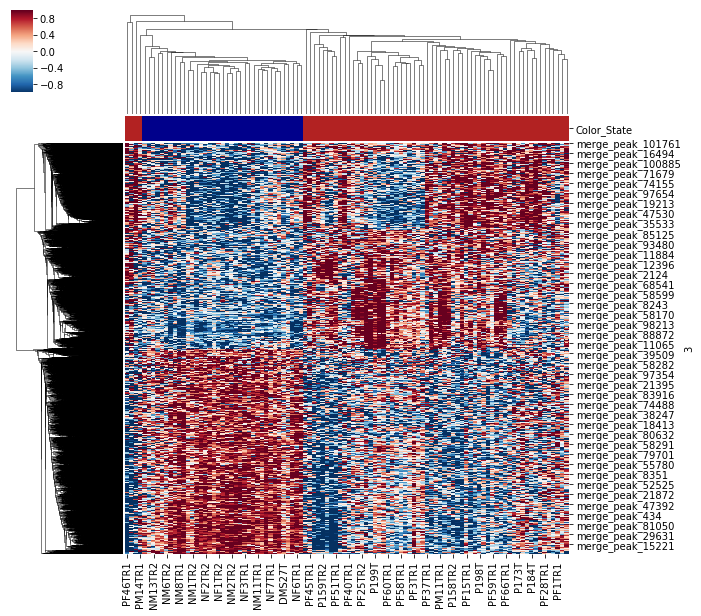

In [17]:
#Remove Gender differential peaks
AllDiffPeaks=[i for i in NormUp+SLEUp if i not in MaleUp+FemaleUp]

fig=sns.clustermap(QNormDFlog.loc[AllDiffPeaks].apply(scipy.stats.zscore,axis=1),method='average',col_colors=SampleAnoDF[['Color_State']],cmap='RdBu_r', vmax=1,vmin=-1)      
plt.show()
fig.savefig(os.path.join(os.path.join(Dir,'DiffPeaks.Heatmap.pdf')))

SaveBed(BedDF.loc[SLEUp], os.path.join(Dir,'SLE_UpRegulatedPeaks.bed'))
SaveBed(BedDF.loc[NormUp], os.path.join(Dir,'Norm_UpRegulatedPeaks.bed'))




# Heterogeneity of SLE patients

In [21]:
Dir=os.path.join(outDir,'Patients_Heterogeneity')
Mkdir(Dir)


0.3
0.32
0.34
0.36
0.38
0.4
0.42
0.44
0.46
0.48
0.5
0.52
0.54
0.56
0.58
0.6
0.62
0.64
0.66
0.68


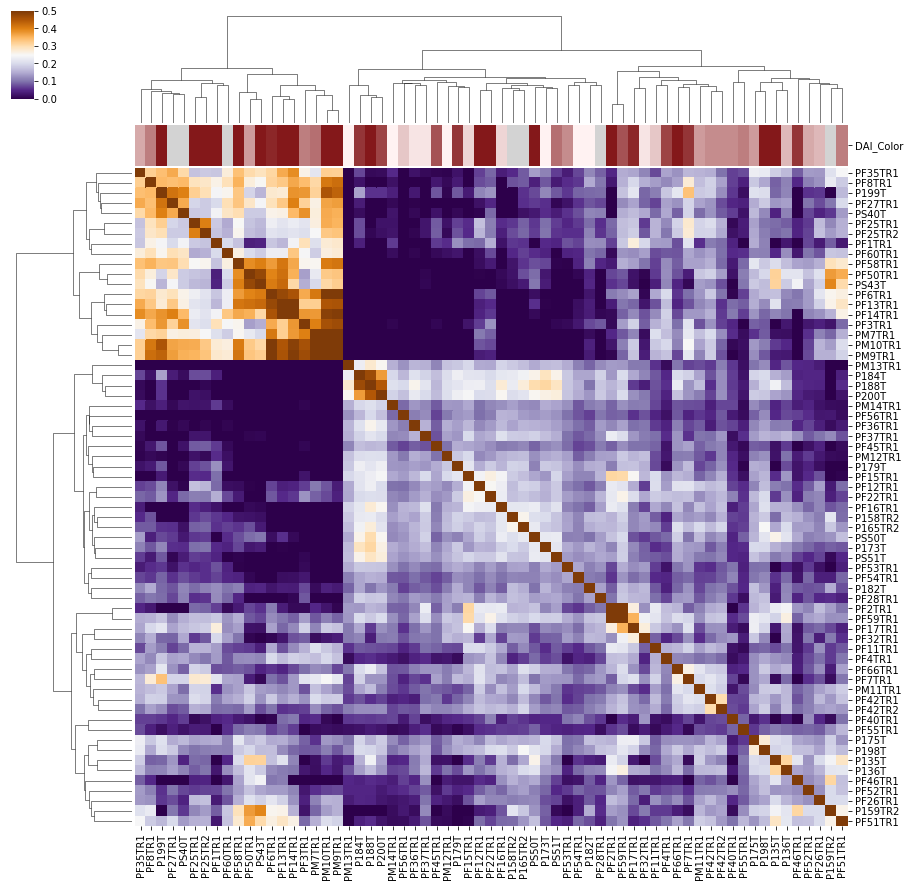

In [12]:
CorDF=pd.DataFrame({},index=list(SLE_QNormDFlog), columns=list(SLE_QNormDFlog)).replace(np.nan,0)


#Patients Correlation Heatmap
# variable peaks selection by coefficient of variation
def COVFilter(InDF,covThreshold):
    DF=InDF[InDF.apply(max,axis=1)>4]
    CovDF=DF.apply(scipy.stats.variation, axis=1)
    FilterDF=DF[CovDF>covThreshold]
    return FilterDF.corr(method='pearson')

for i in range(20):
        print 0.3+i*0.02
        cordf=COVFilter(SLE_QNormDFlog,0.3+i*0.02)
        CorDF=CorDF+cordf


fig=sns.clustermap(CorDF/20.0,cmap='PuOr_r',figsize=(15,15),metric='euclidean',method='complete',vmin=0,vmax=0.5,col_colors=SampleAnoDF.loc[list(CorDF)][['DAI_Color']])                  
plt.show()
fig.savefig(os.path.join(Dir,'Patients_Correlation.pdf'))   



In [22]:
#Identify three patient Groups
Header=list(CorDF)
DAI_Cluster_Dict={'DAI_Hi':[Header[i] for i in fig.dendrogram_col.reordered_ind][0:19],'DAI_Int':[Header[i] for i in fig.dendrogram_col.reordered_ind][43:],'DAI_Low':[Header[i] for i in fig.dendrogram_col.reordered_ind][19:43]}                   
DAI_Cluster_Color_Dict={'DAI_Hi':'#311339','DAI_Int':'#B45853','DAI_Low':'#CEAF9A','Norm':'darkblue'}
DAI_Cluster=[]
for i in list(SampleAnoDF.index):
    if 'P' in i:
        for g in  DAI_Cluster_Dict:
            if i in DAI_Cluster_Dict[g]:
                DAI_Cluster.append(g)
    else:
        DAI_Cluster.append('Norm')
        
SampleAnoDF['DAI_Cluster']=DAI_Cluster
SampleAnoDF['DAI_Cluster_Color']=[DAI_Cluster_Color_Dict[i] for i in DAI_Cluster]



In [23]:
SaveTable(SampleAnoDF,SampleAnoF)

/Users/liuqian/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Norm-DAI_Low:4.411,Norm-DAI_Int:10.331,Norm-DAI_Hi:14.89,DAI_Low-DAI_Int:1.317,DAI_Low-DAI_Hi:2.432,DAI_Int-DAI_Hi:0.566,


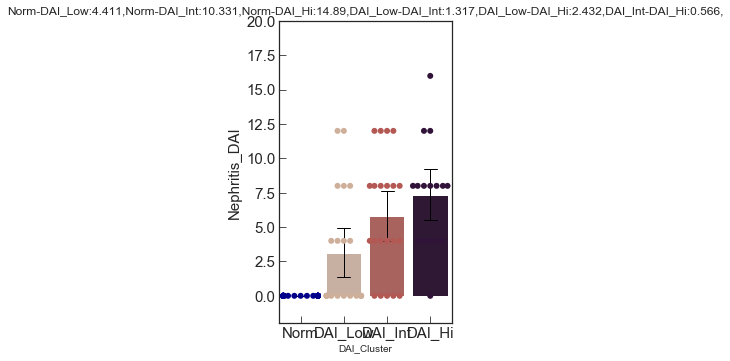

Norm-DAI_Low:10.466,Norm-DAI_Int:24.694,Norm-DAI_Hi:18.154,DAI_Low-DAI_Int:1.015,DAI_Low-DAI_Hi:3.183,DAI_Int-DAI_Hi:2.393,


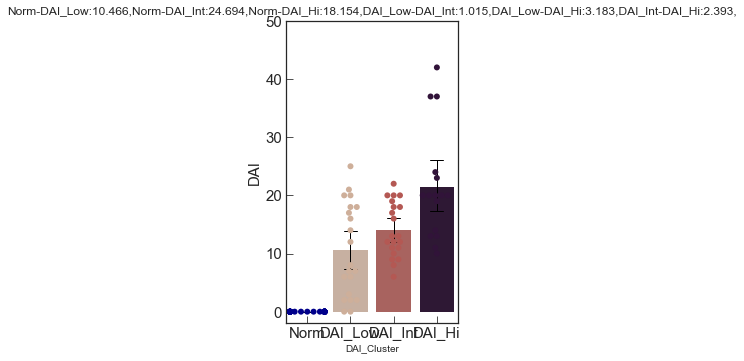

In [24]:
#Summarized the Clinical Information for three Patients Groups
def Sigfinicance(L1,L2):
    return round(log10(scipy.stats.ttest_ind(L1,L2)[1]),3)

def Plot(DF,x,y,xOrder,Dir,label,hue=None,palette=None,color=None,xlim=None,ylim=None):
    #TSS score
    plt.style.use('seaborn-white')
    fig=plt.figure(figsize=(3,6))
    ax=fig.add_axes([0.15,0.25,0.8,0.7])             
    Title=''
    for i,k in enumerate(xOrder):
        for j in range(i+1,len(xOrder)):
            A=DF[DF[x]==k][y]
            B=DF[DF[x]==xOrder[j]][y]
            Title=Title+str(k)+'-'+str(xOrder[j])+':'+str(Sigfinicance(A,B))+','
    ax.set_title(Title)  
    print Title
    ax.tick_params(axis='x',length=7,labelsize=15,direction='in')
    ax.tick_params(axis='y',length=7,labelsize=15,direction='in')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)  
    ax.set_ylabel(y,fontsize=15)
    if palette:
        sns.swarmplot(x=x,y=y,data=DF,order=xOrder,hue=hue,palette=palette,size=6,linewidth=0,ax=ax)
    elif color:
        sns.swarmplot(x=x,y=y,data=DF,order=xOrder,hue=hue,color=color,size=6,linewidth=0,ax=ax)
        
    sns.barplot(x=x, y=y, data=DF, order=xOrder,capsize=.3,palette=palette,ax=ax,errwidth=1,errcolor='k')
    
    fig.savefig(os.path.join(Dir,'A_{}_{}-{}_SwarmPointplot.pdf'.format(label,x,y)))
    plt.show()

Info_SampleAnoDF=SampleAnoDF[SampleAnoDF['DAI_Interval']!='Unknown']
Info_SampleAnoDF['Nephritis_DAI']=[float(i) if i!='Norm' else 0  for i in Info_SampleAnoDF['Nephritis']]
Plot(Info_SampleAnoDF,'DAI_Cluster','Nephritis_DAI',['Norm','DAI_Low','DAI_Int','DAI_Hi'],Dir,'DAI_Cluster',hue=None,palette=DAI_Cluster_Color_Dict,color=None,xlim=None,ylim=[-2,20]) 
Plot(Info_SampleAnoDF,'DAI_Cluster','DAI',['Norm','DAI_Low','DAI_Int','DAI_Hi'],Dir,'DAI_Cluster',hue=None,palette=DAI_Cluster_Color_Dict,color=None,xlim=None,ylim=[-2,50])    



/Users/liuqian/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


Norm-DAI_Low:nan,Norm-DAI_Int:nan,Norm-DAI_Hi:0.887,DAI_Low-DAI_Int:nan,DAI_Low-DAI_Hi:0.589,DAI_Int-DAI_Hi:0.589,


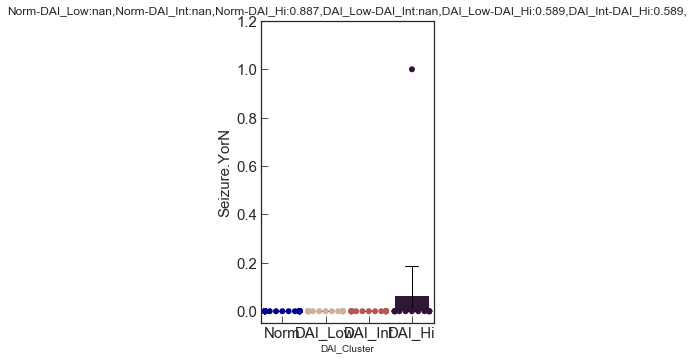

Norm-DAI_Low:nan,Norm-DAI_Int:nan,Norm-DAI_Hi:nan,DAI_Low-DAI_Int:nan,DAI_Low-DAI_Hi:nan,DAI_Int-DAI_Hi:nan,


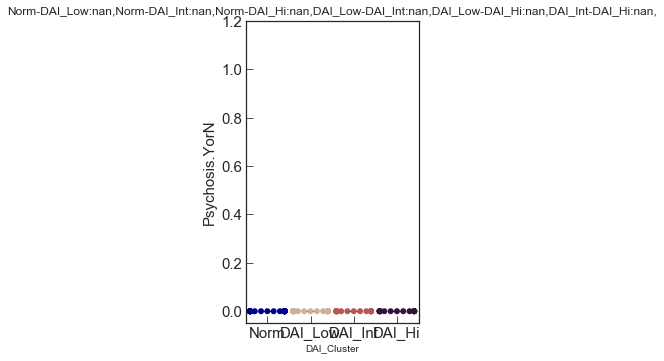

Norm-DAI_Low:1.24,Norm-DAI_Int:nan,Norm-DAI_Hi:1.546,DAI_Low-DAI_Int:0.811,DAI_Low-DAI_Hi:0.108,DAI_Int-DAI_Hi:0.996,


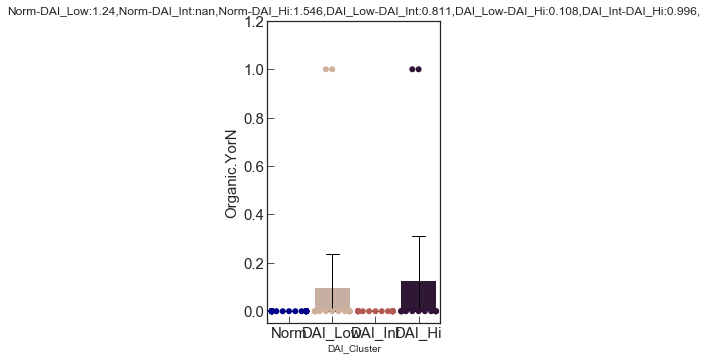

Norm-DAI_Low:nan,Norm-DAI_Int:nan,Norm-DAI_Hi:nan,DAI_Low-DAI_Int:nan,DAI_Low-DAI_Hi:nan,DAI_Int-DAI_Hi:nan,


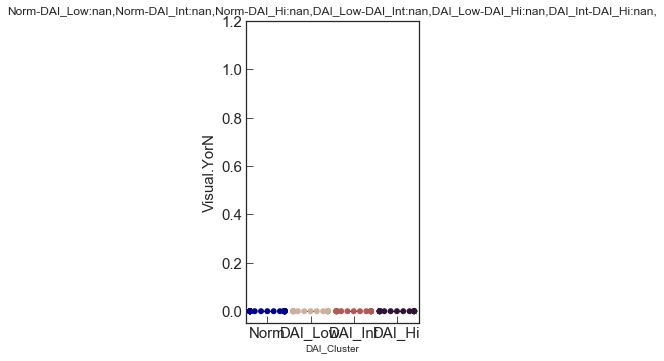

Norm-DAI_Low:nan,Norm-DAI_Int:nan,Norm-DAI_Hi:1.546,DAI_Low-DAI_Int:nan,DAI_Low-DAI_Hi:0.996,DAI_Int-DAI_Hi:0.996,


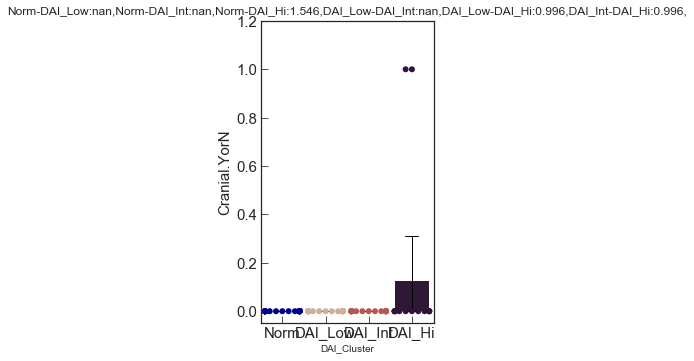

Norm-DAI_Low:nan,Norm-DAI_Int:0.729,Norm-DAI_Hi:1.546,DAI_Low-DAI_Int:0.49,DAI_Low-DAI_Hi:0.996,DAI_Int-DAI_Hi:0.39,


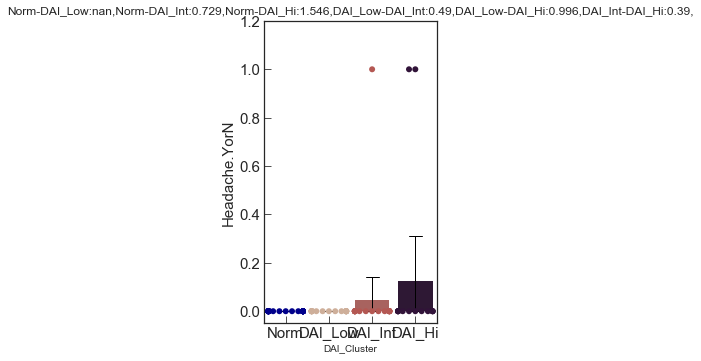

Norm-DAI_Low:nan,Norm-DAI_Int:nan,Norm-DAI_Hi:nan,DAI_Low-DAI_Int:nan,DAI_Low-DAI_Hi:nan,DAI_Int-DAI_Hi:nan,


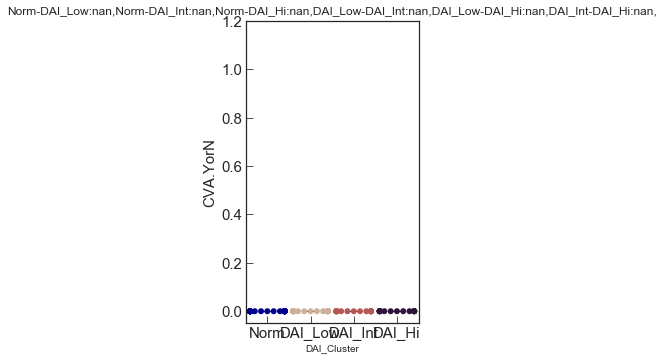

Norm-DAI_Low:0.729,Norm-DAI_Int:0.729,Norm-DAI_Hi:2.939,DAI_Low-DAI_Int:-0.0,DAI_Low-DAI_Hi:1.107,DAI_Int-DAI_Hi:1.107,


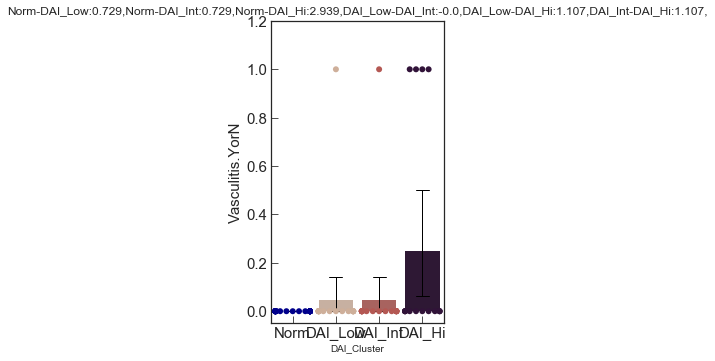

Norm-DAI_Low:6.33,Norm-DAI_Int:10.854,Norm-DAI_Hi:6.636,DAI_Low-DAI_Int:0.654,DAI_Low-DAI_Hi:0.051,DAI_Int-DAI_Hi:0.495,


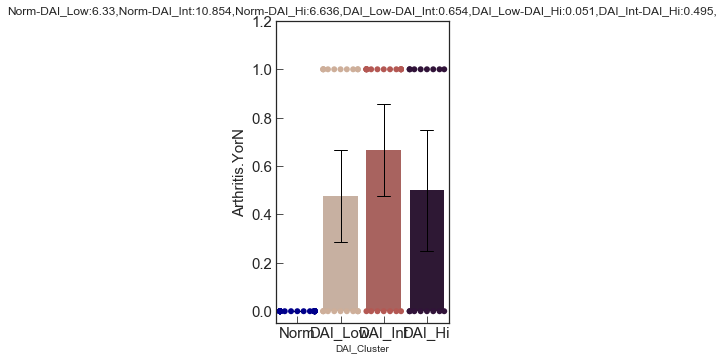

Norm-DAI_Low:nan,Norm-DAI_Int:nan,Norm-DAI_Hi:nan,DAI_Low-DAI_Int:nan,DAI_Low-DAI_Hi:nan,DAI_Int-DAI_Hi:nan,


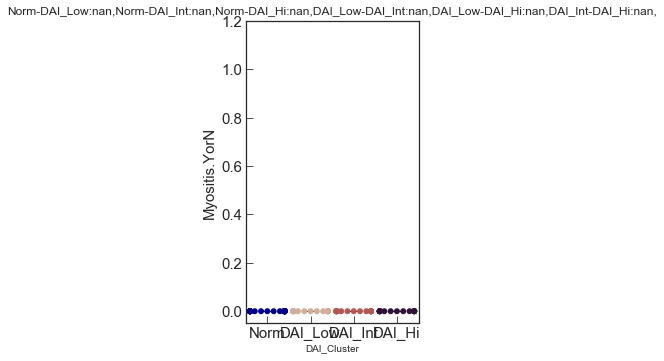

Norm-DAI_Low:nan,Norm-DAI_Int:nan,Norm-DAI_Hi:1.546,DAI_Low-DAI_Int:nan,DAI_Low-DAI_Hi:0.996,DAI_Int-DAI_Hi:0.996,


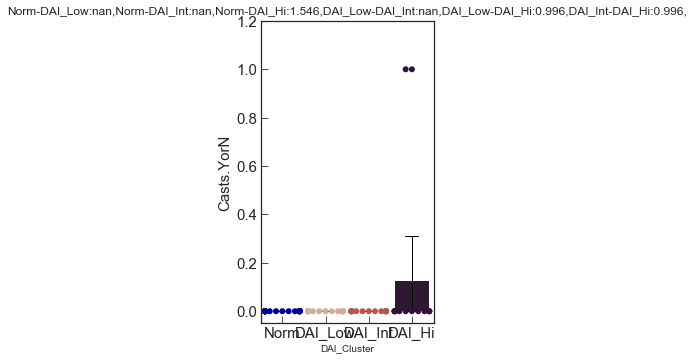

Norm-DAI_Low:3.417,Norm-DAI_Int:7.257,Norm-DAI_Hi:13.383,DAI_Low-DAI_Int:0.915,DAI_Low-DAI_Hi:2.381,DAI_Int-DAI_Hi:0.773,


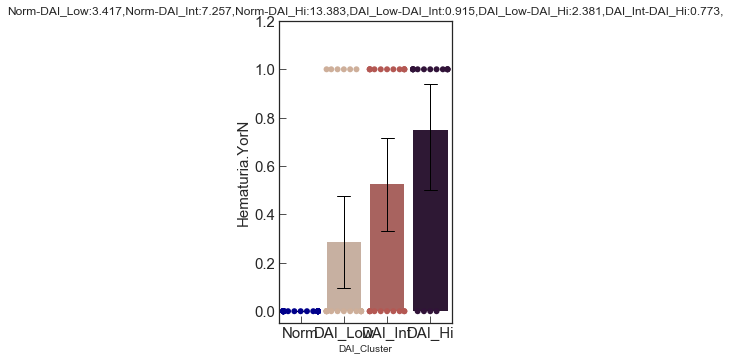

Norm-DAI_Low:3.417,Norm-DAI_Int:8.298,Norm-DAI_Hi:4.581,DAI_Low-DAI_Int:1.196,DAI_Low-DAI_Hi:0.238,DAI_Int-DAI_Hi:0.605,


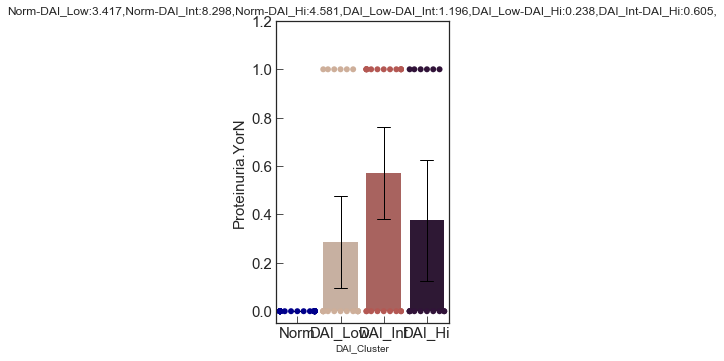

Norm-DAI_Low:2.273,Norm-DAI_Int:4.053,Norm-DAI_Hi:7.894,DAI_Low-DAI_Int:0.517,DAI_Low-DAI_Hi:1.738,DAI_Int-DAI_Hi:0.763,


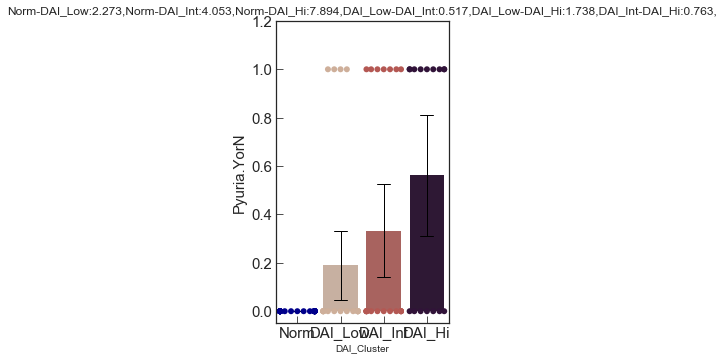

Norm-DAI_Low:1.748,Norm-DAI_Int:4.053,Norm-DAI_Hi:2.939,DAI_Low-DAI_Int:0.811,DAI_Low-DAI_Hi:0.373,DAI_Int-DAI_Hi:0.226,


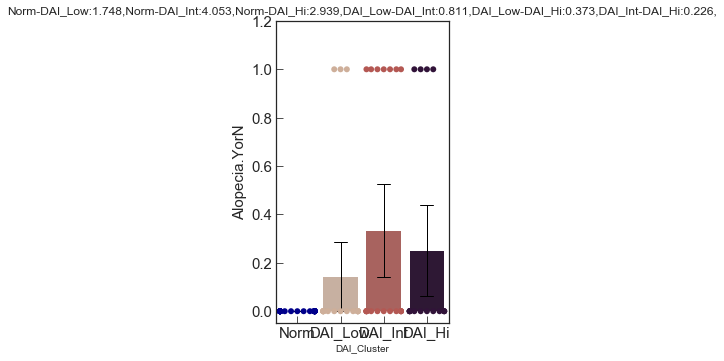

Norm-DAI_Low:7.257,Norm-DAI_Int:6.33,Norm-DAI_Hi:13.383,DAI_Low-DAI_Int:0.117,DAI_Low-DAI_Hi:0.773,DAI_Int-DAI_Hi:1.009,


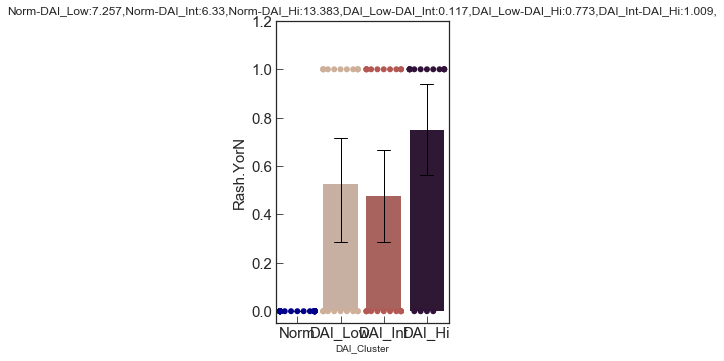

Norm-DAI_Low:1.748,Norm-DAI_Int:0.729,Norm-DAI_Hi:0.887,DAI_Low-DAI_Int:0.516,DAI_Low-DAI_Hi:0.347,DAI_Int-DAI_Hi:0.072,


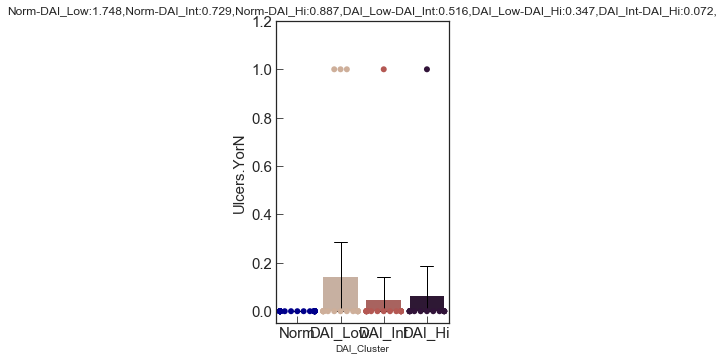

Norm-DAI_Low:1.748,Norm-DAI_Int:0.729,Norm-DAI_Hi:1.546,DAI_Low-DAI_Int:0.516,DAI_Low-DAI_Hi:0.056,DAI_Int-DAI_Hi:0.39,


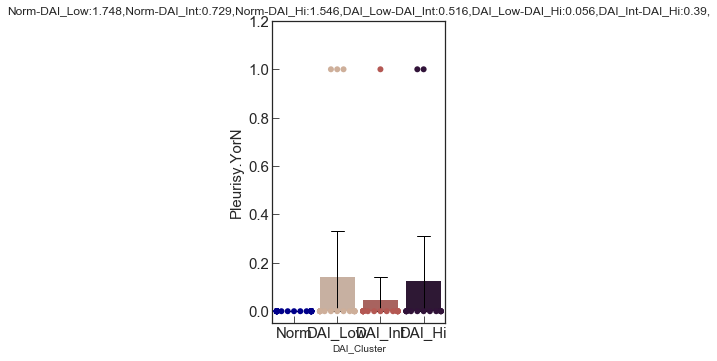

Norm-DAI_Low:1.748,Norm-DAI_Int:1.748,Norm-DAI_Hi:4.581,DAI_Low-DAI_Int:-0.0,DAI_Low-DAI_Hi:0.964,DAI_Int-DAI_Hi:0.964,


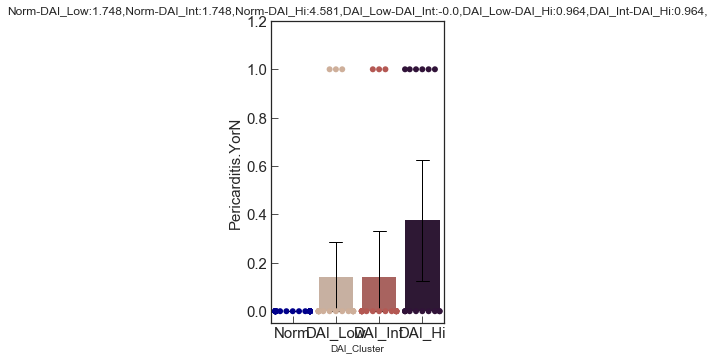

Norm-DAI_Low:7.257,Norm-DAI_Int:14.417,Norm-DAI_Hi:27.955,DAI_Low-DAI_Int:0.948,DAI_Low-DAI_Hi:2.269,DAI_Int-DAI_Hi:0.797,


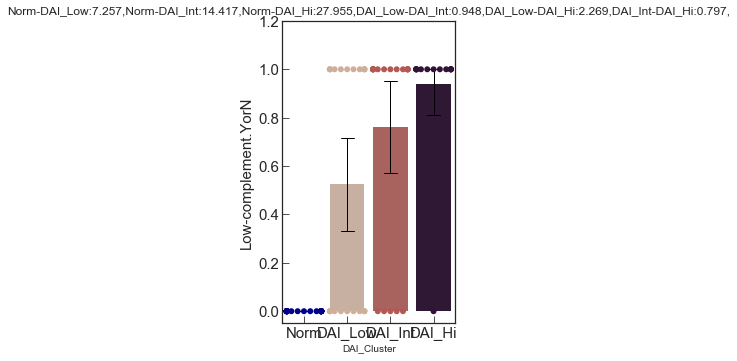

Norm-DAI_Low:8.298,Norm-DAI_Int:6.33,Norm-DAI_Hi:20.547,DAI_Low-DAI_Int:0.261,DAI_Low-DAI_Hi:1.33,DAI_Int-DAI_Hi:1.963,


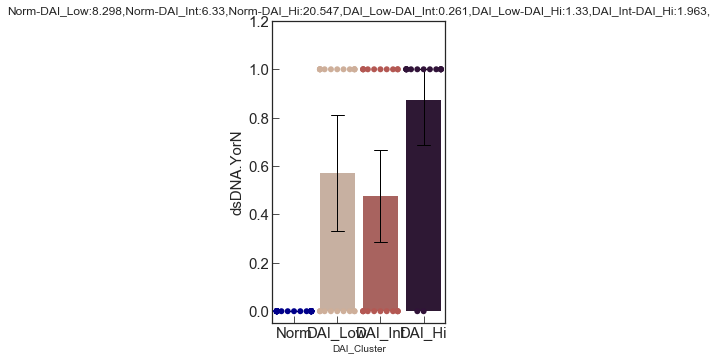

Norm-DAI_Low:nan,Norm-DAI_Int:0.729,Norm-DAI_Hi:2.22,DAI_Low-DAI_Int:0.49,DAI_Low-DAI_Hi:1.405,DAI_Int-DAI_Hi:0.735,


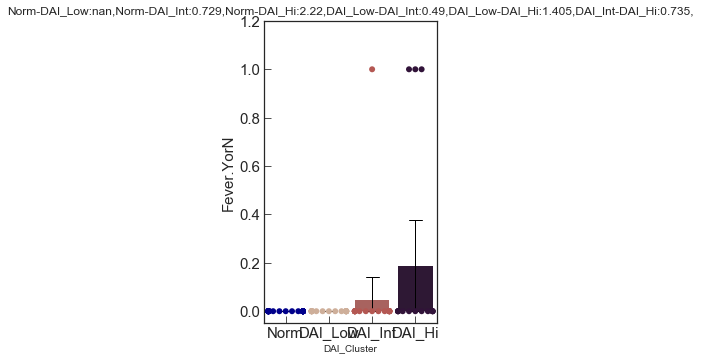

Norm-DAI_Low:2.273,Norm-DAI_Int:4.743,Norm-DAI_Hi:1.546,DAI_Low-DAI_Int:0.744,DAI_Low-DAI_Hi:0.219,DAI_Int-DAI_Hi:1.062,


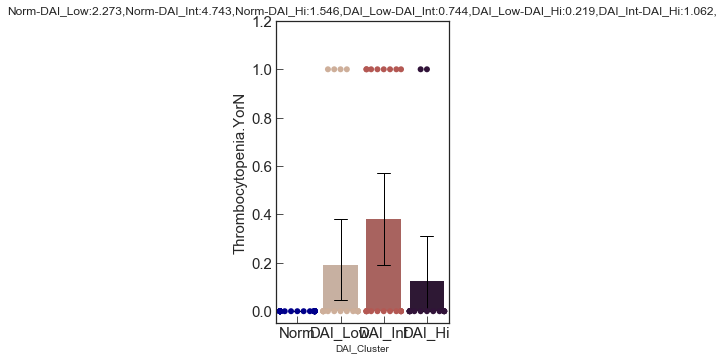

Norm-DAI_Low:2.273,Norm-DAI_Int:1.748,Norm-DAI_Hi:4.581,DAI_Low-DAI_Int:0.163,DAI_Low-DAI_Hi:0.654,DAI_Int-DAI_Hi:0.964,


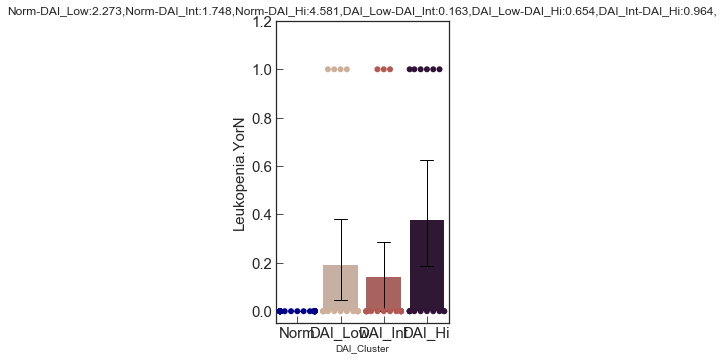

In [25]:
for i in ['Seizure','Psychosis','Organic','Visual','Cranial','Headache','CVA','Vasculitis','Arthritis','Myositis','Casts','Hematuria','Proteinuria','Pyuria',
 'Alopecia','Rash','Ulcers','Pleurisy','Pericarditis','Low-complement','dsDNA','Fever','Thrombocytopenia','Leukopenia']:
    Info_SampleAnoDF[i+'.YorN']=[1 if (x!='Norm') and ((str(x)!='0.0') and (str(x)!='0')) else 0  for x in Info_SampleAnoDF[i]]
    Plot(Info_SampleAnoDF,'DAI_Cluster',i+'.YorN',['Norm','DAI_Low','DAI_Int','DAI_Hi'],Dir,'DAI_Cluster',hue=None,palette=DAI_Cluster_Color_Dict,color=None,xlim=None,ylim=[-0.05,1.2])                  
    


[ 0.23214286  0.41071429  0.54761905  0.24206349  0.          0.          0.
  0.          0.0843254   0.02083333  0.10515873  0.05753968  0.04166667
  0.0734127   0.04166667  0.74107143  0.11507937  0.51984127  0.36210317
  0.2202381   0.23611111  0.58333333  0.64087302]


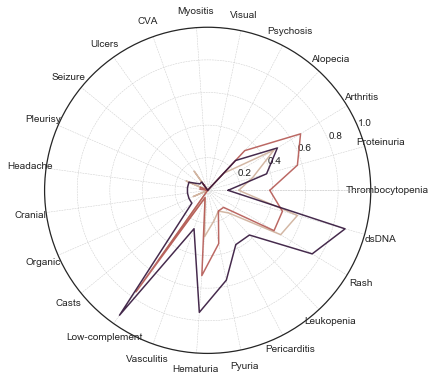

In [26]:
Cmp_Order=['Seizure','Ulcers','Pleurisy','Psychosis','Organic','Visual','Cranial','Headache','CVA','Myositis','Thrombocytopenia','Alopecia','Proteinuria','Arthritis','Vasculitis','Casts','Hematuria','Pyuria','Rash','Pericarditis','Low-complement','dsDNA','Leukopenia']                                        
def RadarPlot(Z_Module_Sample_DF_Sub,Samples,SampleLabel,colorDict,Dir):
    subDF=Z_Module_Sample_DF_Sub[Samples].T
    labels=list(subDF)
    dataLenth =len(labels)
    Samples=list(subDF.index)
    Angles = np.linspace(0, 2*np.pi, dataLenth, endpoint=False)
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111, polar=True)
    #下面之所以要np.concatenate（data,data[0]）是为了让雷达图中的线围成一个圈
    angles = np.concatenate((Angles, [Angles[0]]))
    for i in Samples:
        data=np.array(subDF.loc[i])
        data = np.concatenate((data, [data[0]]))
        ax.plot(angles,data,color=colorDict[i],linestyle='-', linewidth=1.5,alpha=0.9)
    MsubDF=np.array(subDF.apply(np.mean,axis=0))
    print MsubDF
    data = np.concatenate((MsubDF, [MsubDF[0]]))
    #ax.plot(angles, data,color='k',linestyle='-', linewidth=2,alpha=0.8)
    ax.set_thetagrids(angles * 180/np.pi, labels,fontsize='medium')
    ax.grid(True,linestyle='--',linewidth =0.5)
    ax.set_ylim(0,1)
    Outfig=os.path.join(Dir,SampleLabel+'.Complication_RadiaPlot.pdf')
    plt.savefig(Outfig)
    plt.show()
    
DF=Info_SampleAnoDF[Cmp_Order].dropna()
DF=DF[DF['Seizure']!='Norm'].astype('float')

    
DF[DF>0]=1
DAI_L_DF=DF.loc[list(Info_SampleAnoDF[Info_SampleAnoDF['DAI_Cluster']=='DAI_Low'].index)].dropna()
DAI_M_DF=DF.loc[list(Info_SampleAnoDF[Info_SampleAnoDF['DAI_Cluster']=='DAI_Int'].index)].dropna()
DAI_H_DF=DF.loc[list(Info_SampleAnoDF[Info_SampleAnoDF['DAI_Cluster']=='DAI_Hi'].index)].dropna()
Radio_DF=pd.DataFrame({},index=Cmp_Order)
Radio_DF['DAI_Low']=DAI_L_DF.apply(sum,axis=0)/float(len(DAI_L_DF))
Radio_DF['DAI_Int']=DAI_M_DF.apply(sum,axis=0)/float(len(DAI_M_DF))
Radio_DF['DAI_Hi']=DAI_H_DF.apply(sum,axis=0)/float(len(DAI_H_DF))
RadarPlot(Radio_DF.loc[(Radio_DF['DAI_Hi']-Radio_DF['DAI_Int']).sort_values().index],['DAI_Low','DAI_Int','DAI_Hi'],'DAI',DAI_Cluster_Color_Dict,Dir)                      



# Variable Peaks PCA analysis

In [27]:
Dir=os.path.join(outDir,'Variable_Peaks_PCA')
Mkdir(Dir)


In [28]:
def Scatterplot_2D(NoneDF=None,NormDF=None,ScatterDF=None,X='x',Y='y',hue=None,normhue='Group',nonehue='Treated',outFilePrefix=None,hueColorDict=None,sub='AllSamples',legend=True,vmin=-1,vmax=1):                        
    if legend:
        outfig=outFilePrefix+sub+'.ScatterPlot.for'+hue+'.pdf'
    else:
        outfig=outFilePrefix+sub+'.ScatterPlot.withoutLegend.for'+hue+'.pdf'
    plt.style.use('seaborn-white')
    fig=plt.figure(figsize=(6,6))
    ax=fig.add_axes([0.15,0.15,0.8,0.8])
    if type(hueColorDict)==str:
        ScatterDF[hue]=[float(i) for i in ScatterDF[hue]]
        sns.scatterplot(x=X,y=Y,data=NoneDF,hue=nonehue,palette={'Unknown':'lightgrey'},s=100,ax=ax,edgecolor='k',alpha=0.8)
        sns.scatterplot(x=X,y=Y,data=NormDF,hue=normhue,palette={'Norm':'darkblue'},s=100,ax=ax,edgecolor='k',alpha=0.8)
        sns.scatterplot(x=X,y=Y,data=ScatterDF,hue=hue,palette=hueColorDict,s=100,ax=ax,edgecolor='k',hue_norm=(vmin,vmax),alpha=0.8)
        ax.legend(fontsize='large',markerscale=1.5,ncol=1,edgecolor='k',columnspacing=0.1,labelspacing=0.2,handletextpad=0.1)
    elif type(hueColorDict)==dict:
        ax.scatter(NoneDF[X],NoneDF[Y],c='lightgrey',s=100,label='Unknown',edgecolor='k',alpha=0.8)
        ax.scatter(NormDF[X],NormDF[Y],c='darkblue',s=100,label='Norm',edgecolor='k',alpha=0.8)
        for h in hueColorDict:
            c=hueColorDict[h]
            DFsub=ScatterDF[ScatterDF[hue]==h]
            ax.scatter(DFsub[X],DFsub[Y],c=c,s=100,label=h,edgecolor='k',alpha=0.8)
        if legend:
            ax.legend(fontsize='large',markerscale=1,ncol=3,edgecolor='k',columnspacing=0,labelspacing=0,handletextpad=0)
    ax.set_title(sub+'-'+hue,fontsize=20)
    ax.tick_params(axis='x',labelsize=20)
    ax.tick_params(axis='y',labelsize=20)
    ax.set_xlabel(X,fontsize=25)
    ax.set_ylabel(Y,fontsize=25)
    fig.savefig(outfig,dpi=500)
    plt.show()

def Scatterplot_3D(NoneDF=None,NormDF=None,ScatterDF=None,X='x',Y='y',Z='z',hue=None,normhue='Group',nonehue='Treated',outFilePrefix=None,hueColorDict=None,sub='AllSamples',legend=True,vmin=-1,vmax=1):                        
    if legend:
        outfig=outFilePrefix+sub+'.3D.ScatterPlot.for'+hue+'.pdf'
    else:
        outfig=outFilePrefix+sub+'.3D.ScatterPlot.withoutLegend.for'+hue+'.pdf'
    plt.style.use('seaborn-white')
    ax=plt.subplot(111,projection='3d')
    ax.set_xlabel(X,fontsize=20)
    ax.set_ylabel(Y,fontsize=20)
    ax.set_zlabel(Z,fontsize=20) 
    if type(hueColorDict)==str:
        ScatterDF[hue]=[float(i) for i in ScatterDF[hue]]
        ax.scatter(NoneDF[X],NoneDF[Y],NoneDF[Z],c='lightgrey',s=50,label='Unknown',edgecolor='k',alpha=0.8)
        ax.scatter(NormDF[X],NormDF[Y],NormDF[Z],c='darkblue',s=50,label='Norm',edgecolor='k',alpha=0.8)
        ax.scatter(ScatterDF[X],ScatterDF[Y],ScatterDF[Z],c=ScatterDF[hue],cmap=hueColorDict,s=50,label=hue,edgecolor='k',alpha=0.8)
        ax.legend(fontsize='large',markerscale=1.5,ncol=1,edgecolor='k',columnspacing=0.1,labelspacing=0.2,handletextpad=0.1)
    elif type(hueColorDict)==dict:
        ax.scatter(NoneDF[X],NoneDF[Y],NoneDF[Z],c='lightgrey',s=50,label='Unknown',edgecolor='k',alpha=0.8)
        ax.scatter(NormDF[X],NormDF[Y],NormDF[Z],c='darkblue',s=50,label='Norm',edgecolor='k',alpha=0.8)
        for h in hueColorDict:
            c=hueColorDict[h]
            DFsub=ScatterDF[ScatterDF[hue]==h]
            ax.scatter(DFsub[X],DFsub[Y],DFsub[Z],c=c,s=50,label=h,edgecolor='k',alpha=0.8)
        if legend:
            ax.legend(fontsize='large',markerscale=1,ncol=3,edgecolor='k',columnspacing=0,labelspacing=0,handletextpad=0)
    ax.set_title(sub+'-'+hue,fontsize=20)
    ax.tick_params(axis='x',labelsize=20)
    ax.tick_params(axis='y',labelsize=20)
    plt.savefig(outfig,dpi=500)
    plt.show()    
    


In [29]:
Jug=QNormDFlog[QNormDFlog.apply(max,axis=1)>4].apply(scipy.stats.variation, axis=1)>0.2
QNormDFlog_VarPeaks=QNormDFlog.loc[list(Jug[Jug].index)]
pca=PCA(n_components=20)
pca.fit(QNormDFlog_VarPeaks)  
pca_ratio=pca.explained_variance_ratio_
PCA_DF=pd.DataFrame(np.transpose(pca.components_),index=QNormDFlog_VarPeaks.columns)
SampleAnoDF['PC1']=PCA_DF.loc[SampleAnoDF.index][0]
SampleAnoDF['PC2']=PCA_DF.loc[SampleAnoDF.index][1]
SampleAnoDF['PC3']=PCA_DF.loc[SampleAnoDF.index][2]


PC1 PC2 PC3


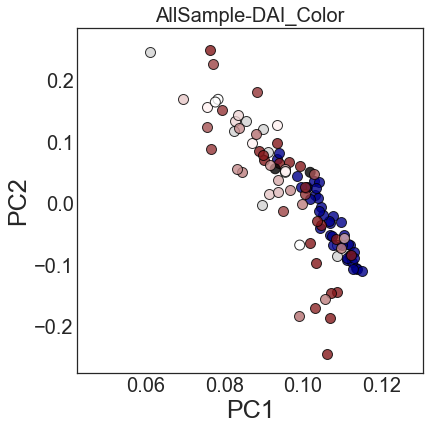

/Users/liuqian/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


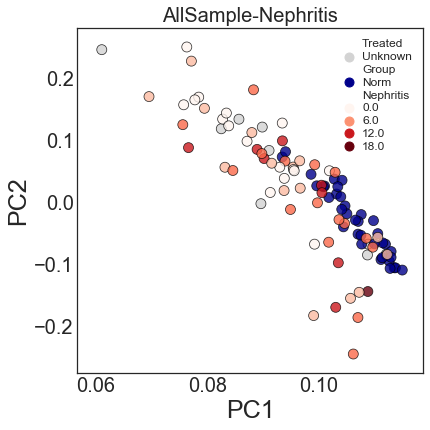

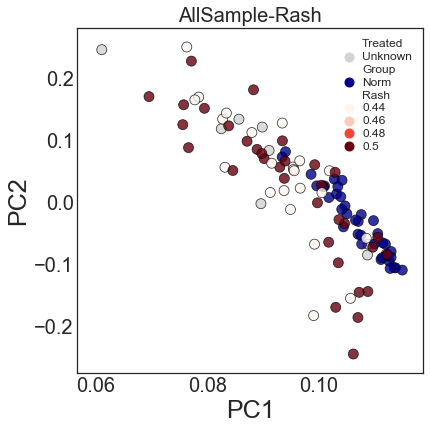

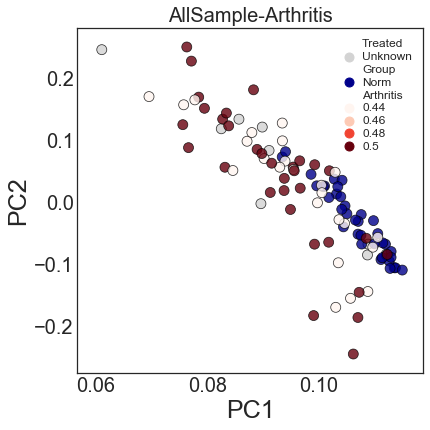

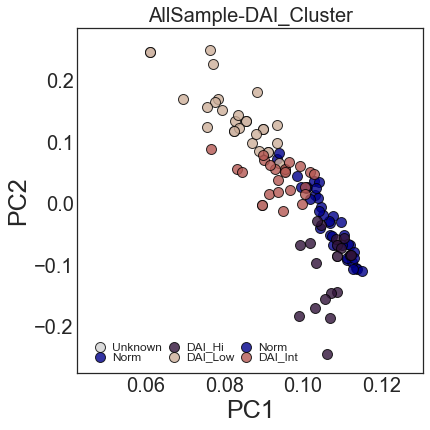

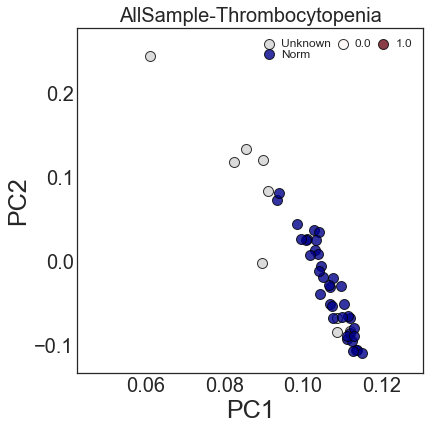

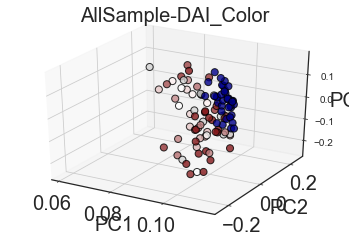

/Users/liuqian/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


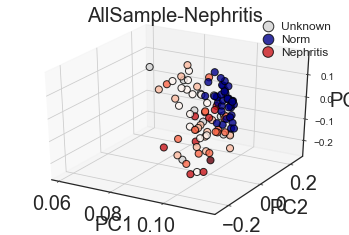

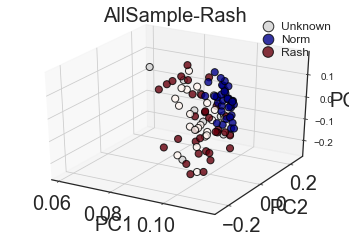

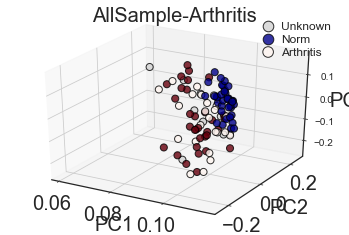

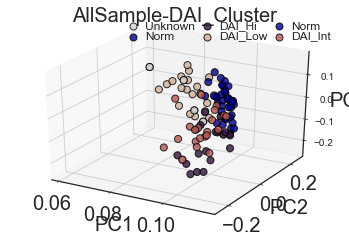

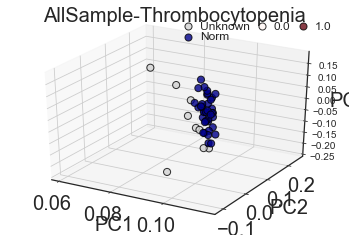

PC1 PC3 PC2


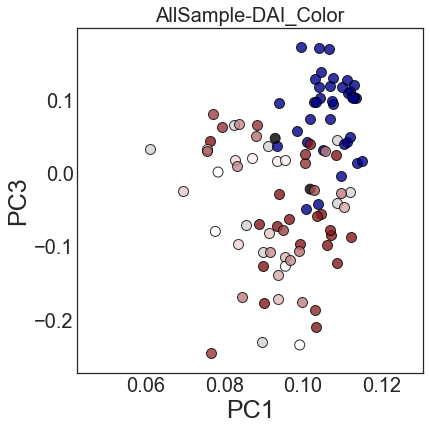

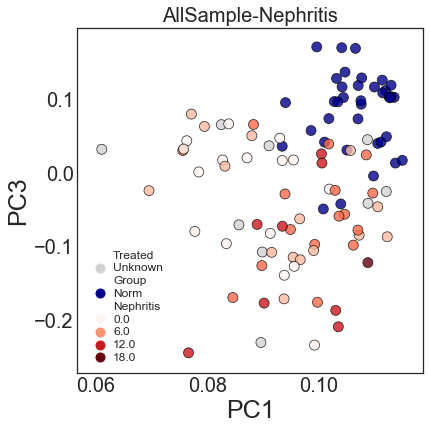

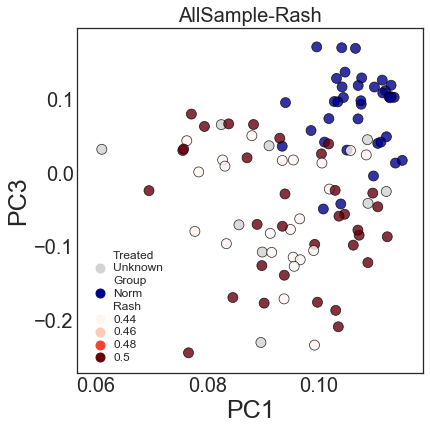

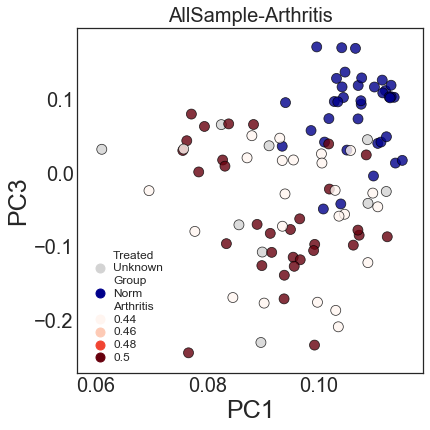

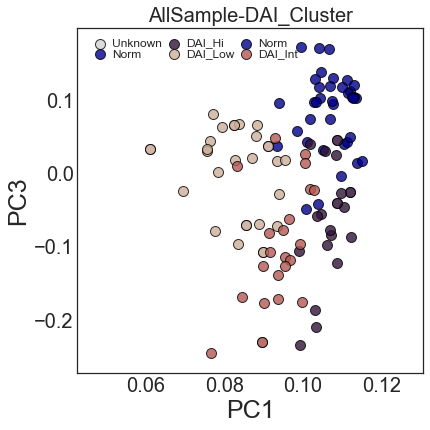

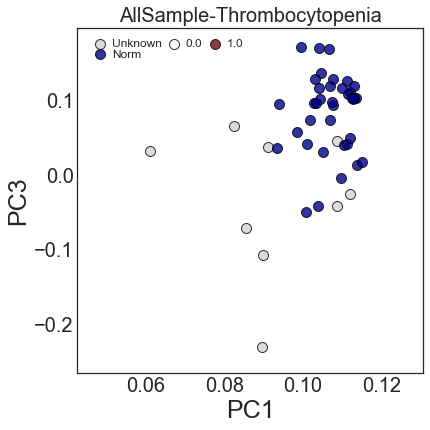

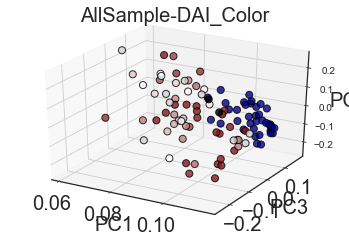

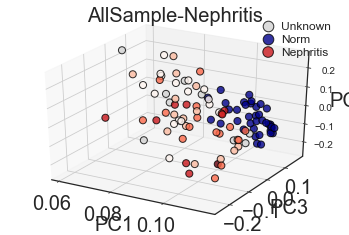

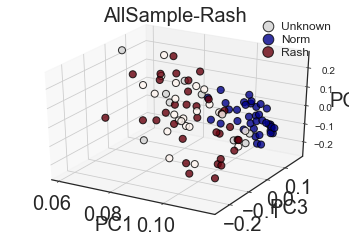

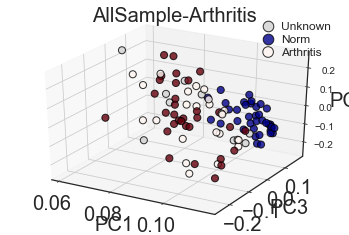

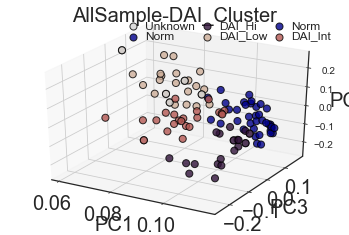

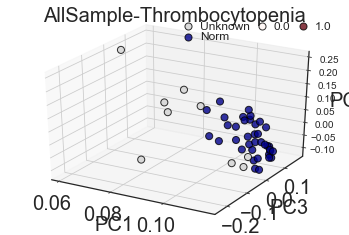

PC2 PC1 PC3


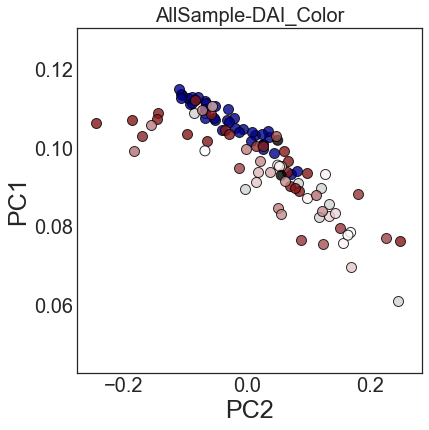

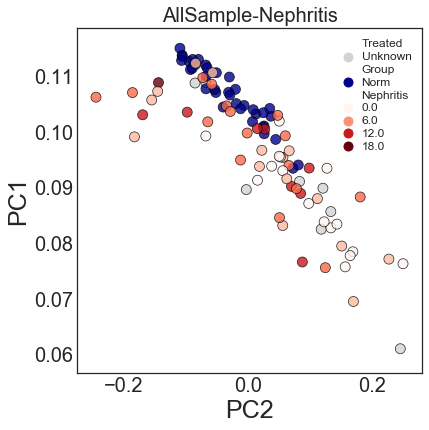

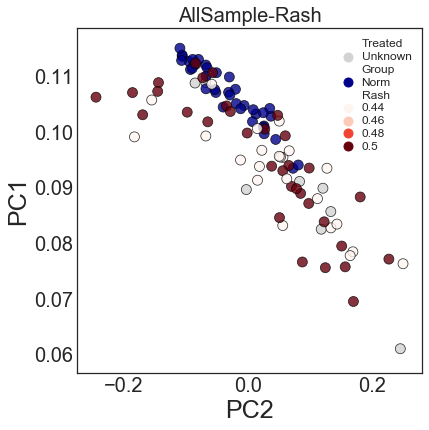

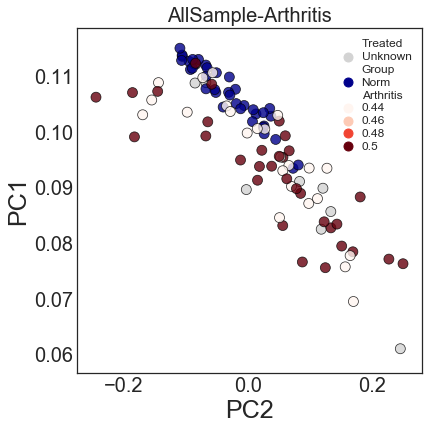

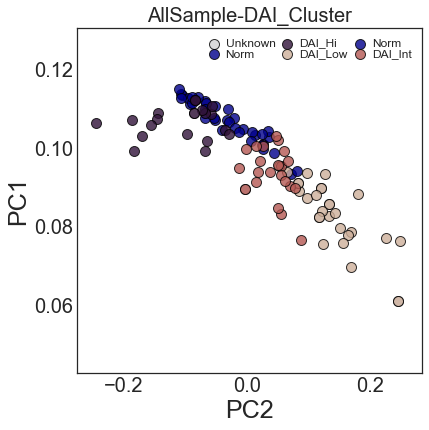

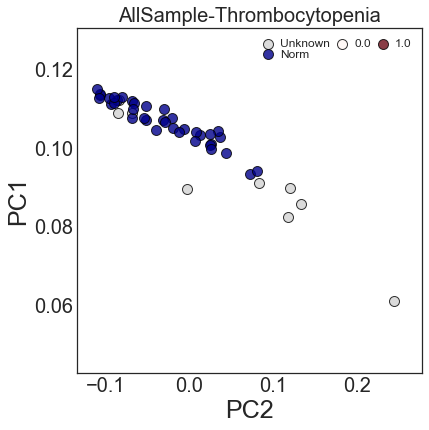

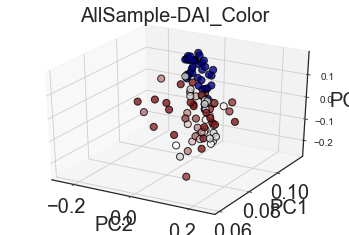

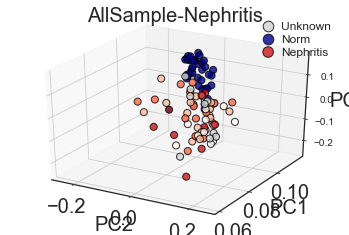

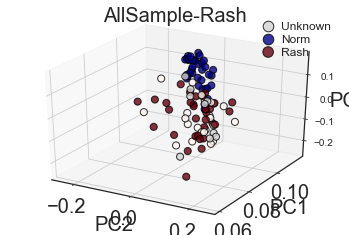

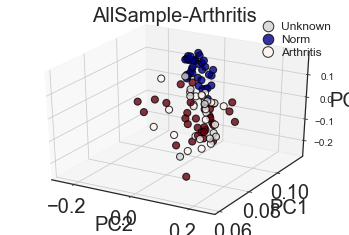

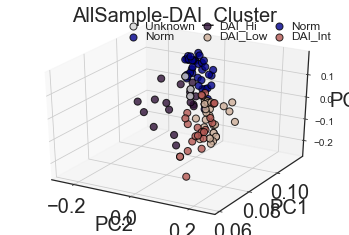

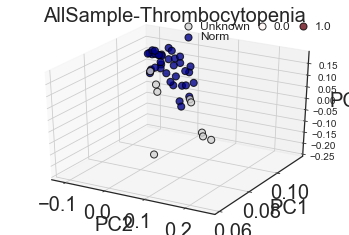

PC2 PC3 PC1


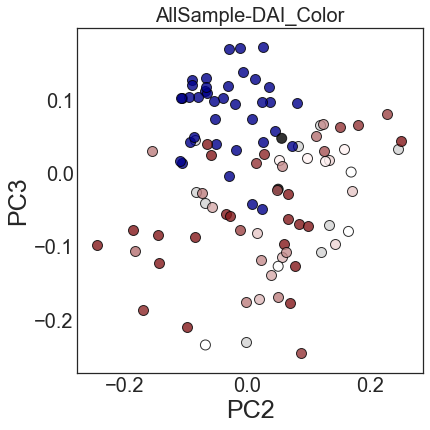

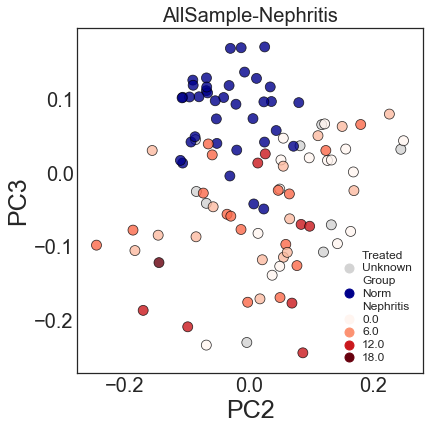

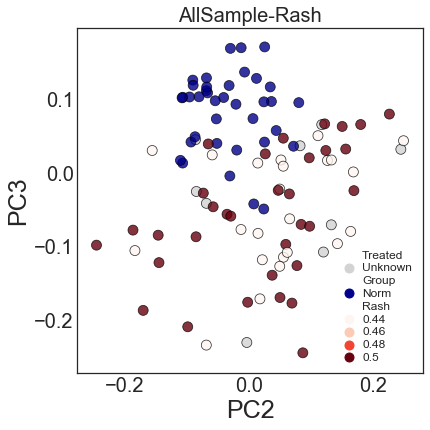

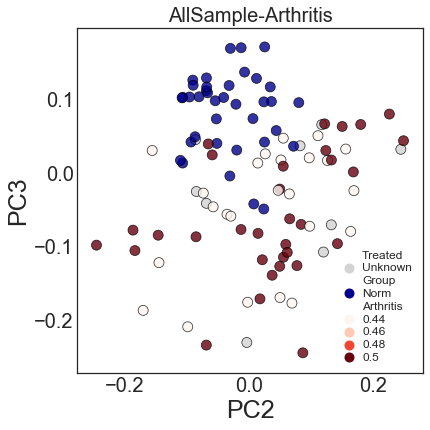

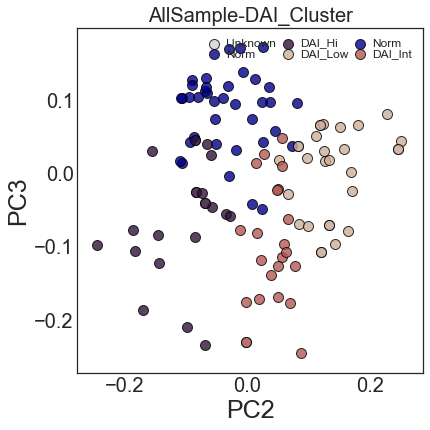

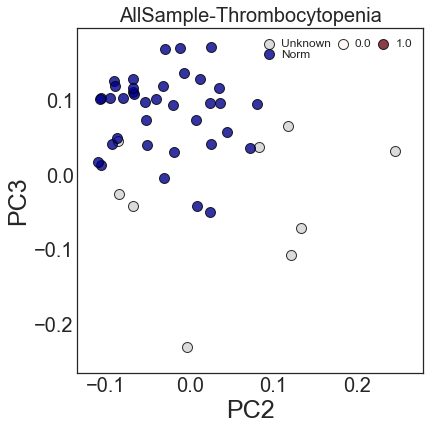

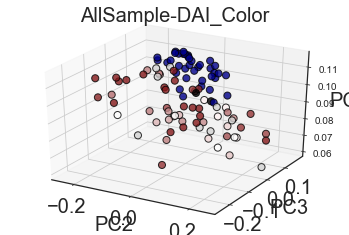

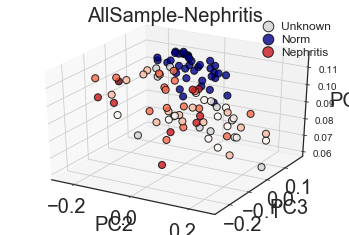

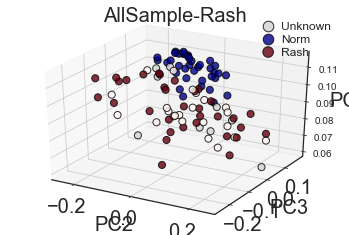

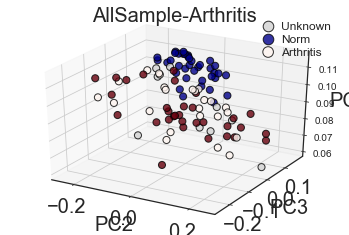

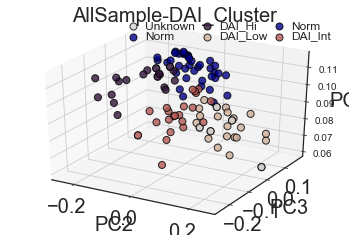

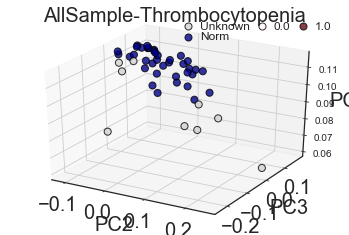

PC3 PC2 PC1


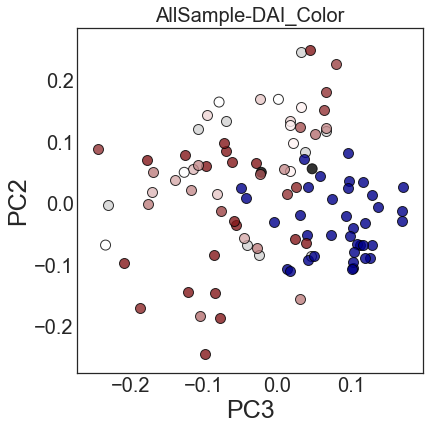

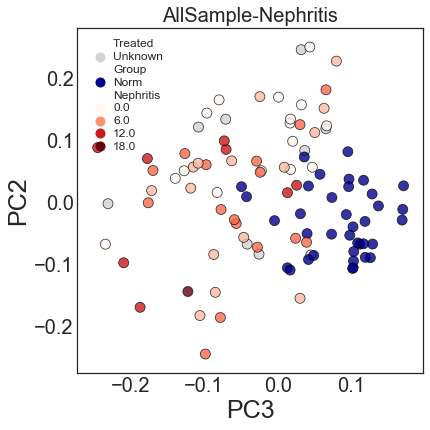

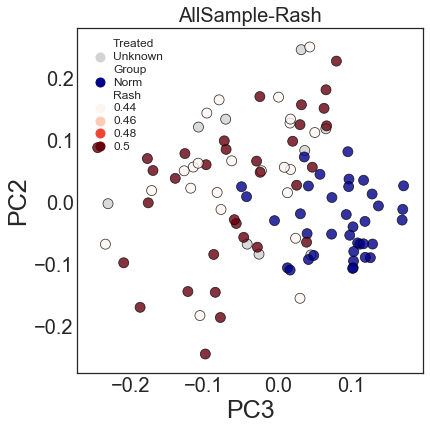

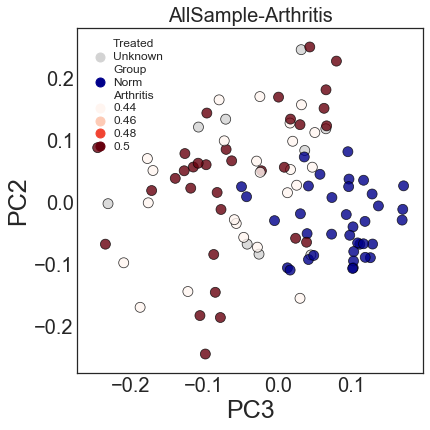

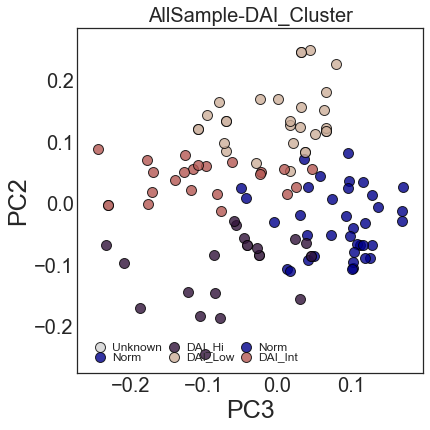

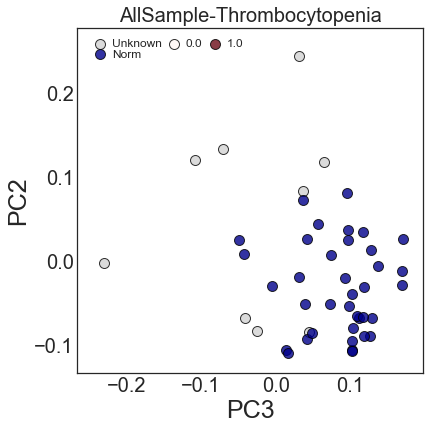

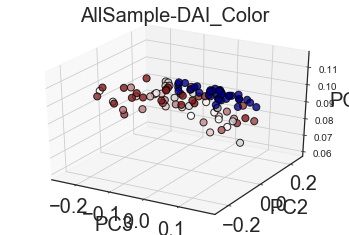

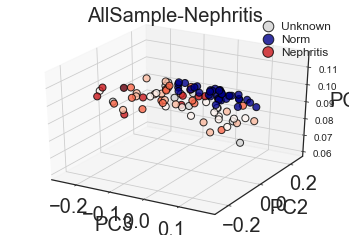

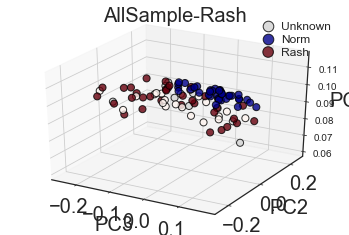

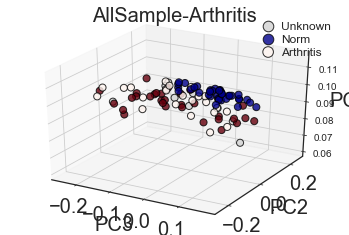

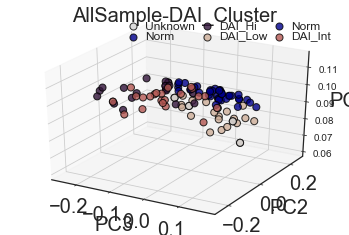

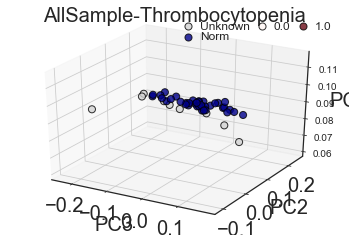

PC3 PC1 PC2


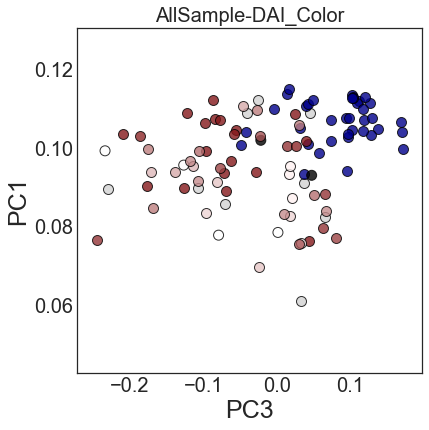

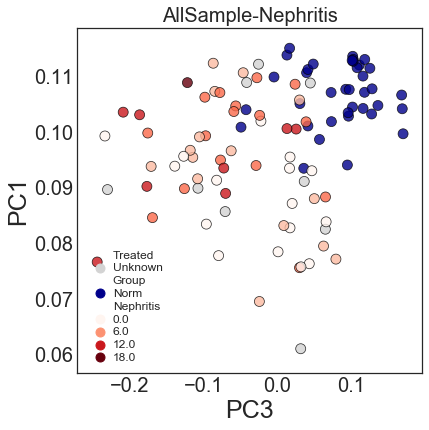

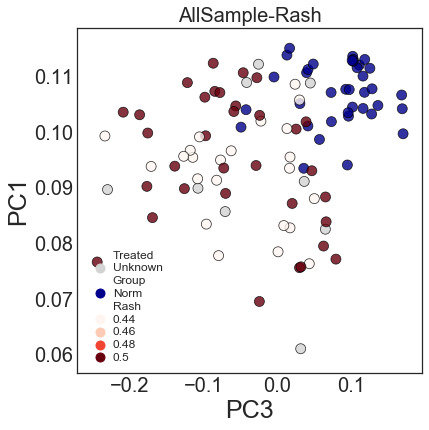

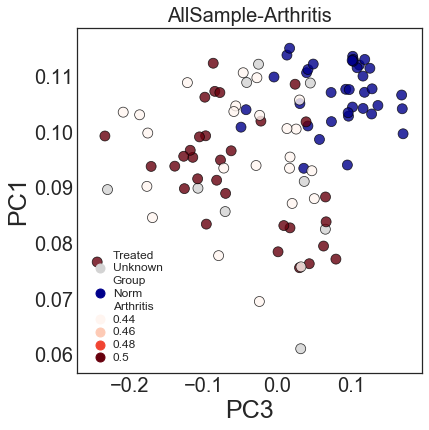

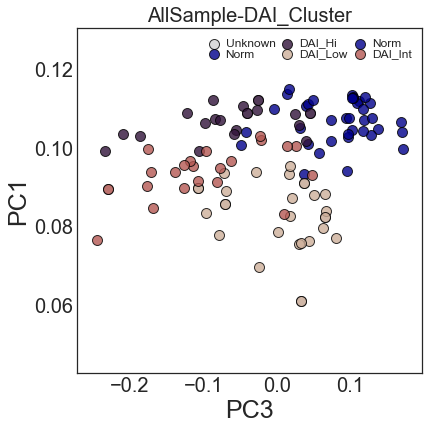

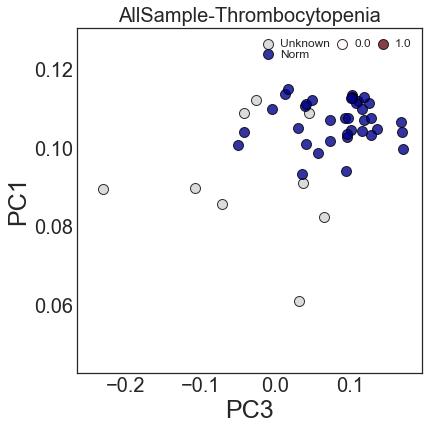

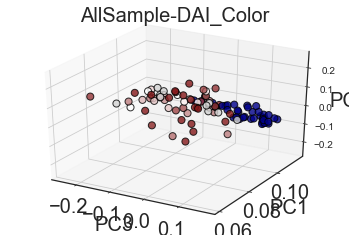

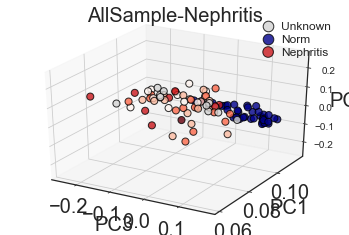

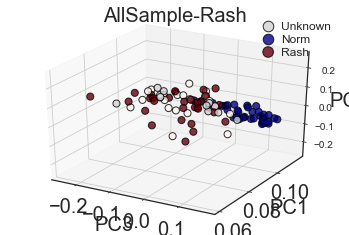

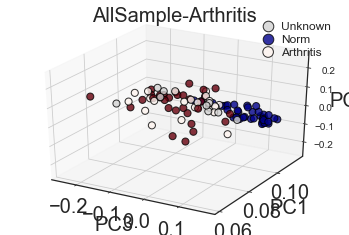

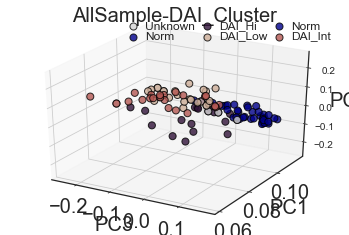

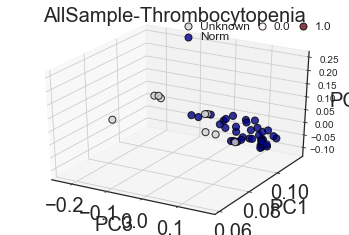

In [31]:
pcaDir=os.path.join(Dir,'AllSample_PCA_PC1_{}_PC2_{}_PC3_{}'.format(str(pca_ratio[0])[:4],str(pca_ratio[1])[:4],str(pca_ratio[2])[:4]))
Mkdir(pcaDir)

for x,y,z in [['PC1','PC2','PC3'],['PC1','PC3','PC2'],['PC2','PC1','PC3'],['PC2','PC3','PC1'],['PC3','PC2','PC1'],['PC3','PC1','PC2']]:                                                                                                              
    print x,y,z
    NormDF=SampleAnoDF[SampleAnoDF['Treated']=='Norm']
    ScatterDF=SampleAnoDF[(SampleAnoDF['Treated']!='Unknown') &(SampleAnoDF['Treated']!='Norm')]
    NoneDF=SampleAnoDF[SampleAnoDF['Treated']=='Unknown']
    pca_outFilePrefix=os.path.join(pcaDir,'{}_{}_{}'.format(x,y,z))
        
        
    Scatterplot_2D(NoneDF=NoneDF,NormDF=NormDF,ScatterDF=ScatterDF,X=x,Y=y,hue='DAI_Color',normhue='Group',nonehue='Treated',outFilePrefix=pca_outFilePrefix,hueColorDict=dict(zip(list(set(SampleAnoDF['DAI_Color'])),list(set(SampleAnoDF['DAI_Color'])))),sub='AllSample',legend=False,vmin=10,vmax=20)
    Scatterplot_2D(NoneDF=NoneDF,NormDF=NormDF,ScatterDF=ScatterDF,X=x,Y=y,hue='Nephritis',normhue='Group',nonehue='Treated',outFilePrefix=pca_outFilePrefix,hueColorDict='Reds',sub='AllSample',legend=True,vmin=0,vmax=16)                                                                                                                
    Scatterplot_2D(NoneDF=NoneDF,NormDF=NormDF,ScatterDF=ScatterDF,X=x,Y=y,hue='Rash',normhue='Group',nonehue='Treated',outFilePrefix=pca_outFilePrefix,hueColorDict='Reds',sub='AllSample',legend=True,vmin=0.45,vmax=0.5)
    Scatterplot_2D(NoneDF=NoneDF,NormDF=NormDF,ScatterDF=ScatterDF,X=x,Y=y,hue='Arthritis',normhue='Group',nonehue='Treated',outFilePrefix=pca_outFilePrefix,hueColorDict='Reds',sub='AllSample',legend=True,vmin=0.45,vmax=0.5)
    Scatterplot_2D(NoneDF=NoneDF,NormDF=NormDF,ScatterDF=SampleAnoDF[SampleAnoDF['Treated']!='Norm'],X=x,Y=y,hue='DAI_Cluster',normhue='Group',nonehue='Treated',outFilePrefix=pca_outFilePrefix,hueColorDict=DAI_Cluster_Color_Dict,sub='AllSample',legend=True,vmin=0.45,vmax=0.5)
    Scatterplot_2D(NoneDF=NoneDF,NormDF=NormDF,ScatterDF=ScatterDF,X=x,Y=y,hue='Thrombocytopenia',normhue='Group',nonehue='Treated',outFilePrefix=pca_outFilePrefix,hueColorDict={'0.0':'#FFF7F4','1.0':'#6C0C18'},sub='AllSample',legend=True,vmin=10,vmax=20)

    Scatterplot_3D(NoneDF=NoneDF,NormDF=NormDF,ScatterDF=ScatterDF,X=x,Y=y,Z=z,hue='DAI_Color',normhue='Group',nonehue='Treated',outFilePrefix=pca_outFilePrefix,hueColorDict=dict(zip(list(set(SampleAnoDF['DAI_Color'])),list(set(SampleAnoDF['DAI_Color'])))),sub='AllSample',legend=False,vmin=10,vmax=20)
    Scatterplot_3D(NoneDF=NoneDF,NormDF=NormDF,ScatterDF=ScatterDF,X=x,Y=y,Z=z,hue='Nephritis',normhue='Group',nonehue='Treated',outFilePrefix=pca_outFilePrefix,hueColorDict='Reds',sub='AllSample',legend=True,vmin=0,vmax=16)
    Scatterplot_3D(NoneDF=NoneDF,NormDF=NormDF,ScatterDF=ScatterDF,X=x,Y=y,Z=z,hue='Rash',normhue='Group',nonehue='Treated',outFilePrefix=pca_outFilePrefix,hueColorDict='Reds',sub='AllSample',legend=True,vmin=0.45,vmax=0.5)
    Scatterplot_3D(NoneDF=NoneDF,NormDF=NormDF,ScatterDF=ScatterDF,X=x,Y=y,Z=z,hue='Arthritis',normhue='Group',nonehue='Treated',outFilePrefix=pca_outFilePrefix,hueColorDict='Reds',sub='AllSample',legend=True,vmin=0.45,vmax=0.5)
    Scatterplot_3D(NoneDF=NoneDF,NormDF=NormDF,ScatterDF=SampleAnoDF[SampleAnoDF['Treated']!='Norm'],X=x,Y=y,Z=z,hue='DAI_Cluster',normhue='Group',nonehue='Treated',outFilePrefix=pca_outFilePrefix,hueColorDict=DAI_Cluster_Color_Dict,sub='AllSample',legend=True,vmin=0.45,vmax=0.5)
    Scatterplot_3D(NoneDF=NoneDF,NormDF=NormDF,ScatterDF=ScatterDF,X=x,Y=y,Z=z,hue='Thrombocytopenia',normhue='Group',nonehue='Treated',outFilePrefix=pca_outFilePrefix,hueColorDict={'0.0':'#FFF7F4','1.0':'#6C0C18'},sub='AllSample',legend=True,vmin=10,vmax=20)
    
    
    

In [32]:
#Average Distance at PCA space 
def Distance(L1,L2): return math.sqrt(sum([i**2 for i in np.array(L1)-np.array(L2)]))
def Average(L):
    Dis=[]
    for i in range(len(L)):
        for j in range(i, len(L)):
            Dis.append(Distance(L[i],L[j]))
    print len(Dis)
    return Dis

PCASpace=SampleAnoDF[['PC1','PC2','PC3']]
NormSamples=list(SampleAnoDF[SampleAnoDF['Group']=='Norm'].index)
SLESamples=list(SampleAnoDF[SampleAnoDF['Group']!='Norm'].index)

NormDis=Average(np.array(PCASpace.loc[NormSamples]))
SLEDis=Average(np.array(PCASpace.loc[SLESamples]))
print(np.mean(NormDis))
print(np.mean(SLEDis))
print(scipy.stats.ttest_ind(NormDis,SLEDis))


     

703
2145
0.0917198062484
0.169702469149
Ttest_indResult(statistic=-20.718501510482454, pvalue=6.2697560941015106e-89)


# Screening the Differential Peaks between SLE patients and Normal controls

In [27]:
Dir=os.path.join(outDir,'ThreeSLEGroups_VS_AllNorm_DiffPeaks')
Mkdir(Dir)


In [28]:
#Differential Peaks
DAI_L_DF=QNormDFlog[list(Info_SampleAnoDF[Info_SampleAnoDF['DAI_Cluster']=='DAI_Low'].index)]
DAI_M_DF=QNormDFlog[list(Info_SampleAnoDF[Info_SampleAnoDF['DAI_Cluster']=='DAI_Int'].index)]
DAI_H_DF=QNormDFlog[list(Info_SampleAnoDF[Info_SampleAnoDF['DAI_Cluster']=='DAI_Hi'].index)]
Norm_DF=QNormDFlog[list(Info_SampleAnoDF[Info_SampleAnoDF['DAI_Cluster']=='Norm'].index)]
SLE_DF=QNormDFlog[list(Info_SampleAnoDF[Info_SampleAnoDF['DAI_Cluster']!='Norm'].index)]

def DiffPeaks_FDR(A,B,fdc,fdr,m):
    A=A[(A.apply(np.max,axis=1)>m)|(B.apply(np.max,axis=1)>m)]
    B=B.loc[A.index]
    print len(A)
    a,b,c,d=Diff_FDR(A,B,fdc,fdr)
    print len(c),len(d)
    return a,b,c,d
    
    
DAI_L_FDC,DAI_L_FDR,DAI_L_Up,DAI_L_Down=DiffPeaks_FDR(DAI_L_DF,Norm_DF,1.2,0.05,4)
DAI_M_FDC,DAI_M_FDR,DAI_M_Up,DAI_M_Down=DiffPeaks_FDR(DAI_M_DF,Norm_DF,1.2,0.05,4)
DAI_H_FDC,DAI_H_FDR,DAI_H_Up,DAI_H_Down=DiffPeaks_FDR(DAI_H_DF,Norm_DF,1.2,0.05,4)



84529
84529
3368 1593
82057
82057
1814 2000
77674
77674
3383 2211


In [29]:
AllDiffPeaks=list(set(DAI_L_Up+DAI_L_Down+DAI_M_Up+DAI_M_Down+DAI_H_Up+DAI_H_Down))
len(AllDiffPeaks)


11786

In [30]:
QNormDFlog_Zscore=QNormDFlog.apply(scipy.stats.zscore,axis=1)


In [31]:
#AllDiffPeaks=list(ReadTable('/Users/liuqian/Documents/A_SLE_project2/ATAC_seq/T_cell/RemoveChrY_20190325/RemoveChrY_20190711/AllDAICluster.AllSpecificPeaks/AA_NormPatientCluster_DiffPeaks_r_1.2_fdr_0.05_m_4/AllCluster.count.txt').index)        


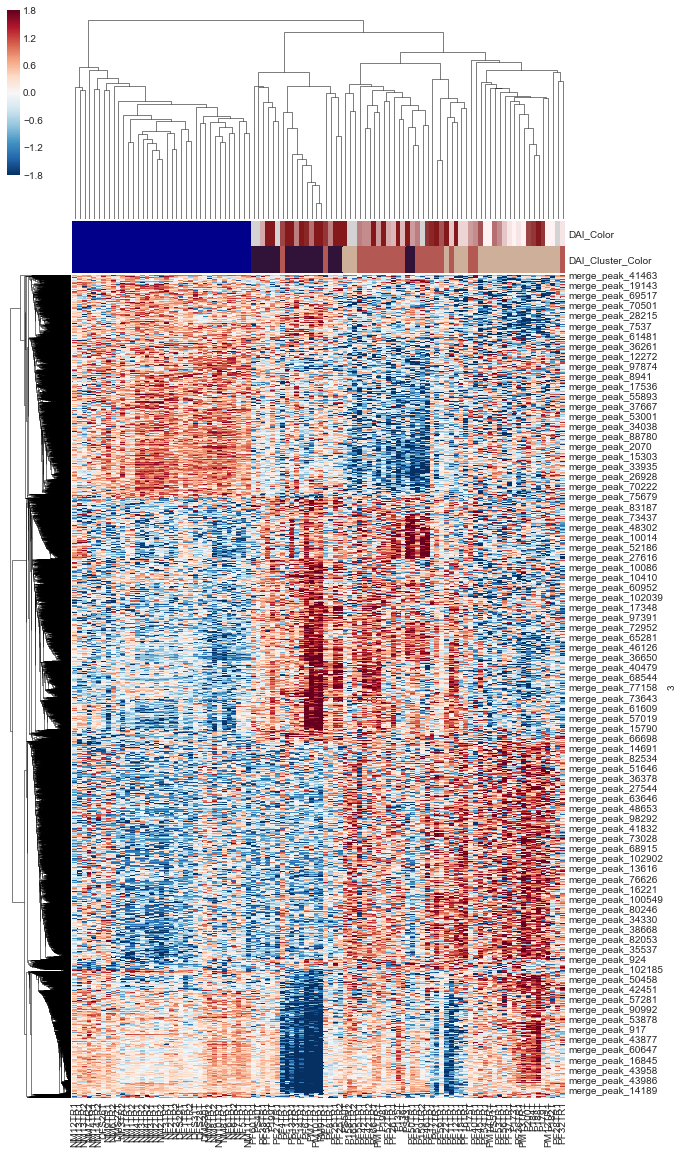

In [32]:
SaveTable(QNormDFlog.loc[AllDiffPeaks], os.path.join(Dir,'AllDiffPeaks.QNormLog.txt'))
fig=sns.clustermap(QNormDFlog_Zscore.loc[AllDiffPeaks],figsize=(10,20),method='average',metric='correlation',cmap='RdBu_r',col_colors=SampleAnoDF[['DAI_Color','DAI_Cluster_Color']],row_cluster=True,col_cluster=True,xticklabels=list(QNormDFlog),linecolor=None,vmin=-1.8,vmax=1.8,annot_kws={"size": 1}) 
plt.savefig(os.path.join(Dir, 'QNormDFlog_DiffPeaks.Count.pdf'))   
plt.show()



In [33]:
Peaks=[AllDiffPeaks[i] for i in fig.dendrogram_row.reordered_ind]
Info_SampleAnoDF_SLE=Info_SampleAnoDF[Info_SampleAnoDF['DAI_Cluster']!='Norm']

C1_Peaks=[Peaks[i] for i in range(0,3234)]
C2_Peaks=[Peaks[i] for i in range(3234,6545)]
C3_Peaks=[Peaks[i] for i in range(6545,9779)]
C4_Peaks=[Peaks[i] for i in range(9779,10010)]
C5_Peaks=[Peaks[i] for i in range(10010,len(AllDiffPeaks))]


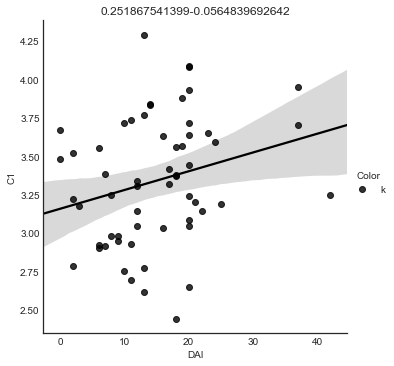

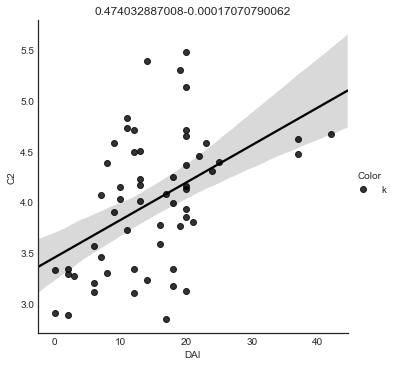

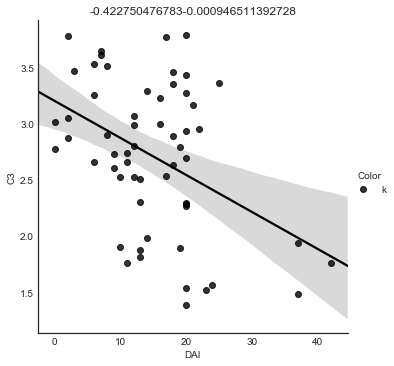

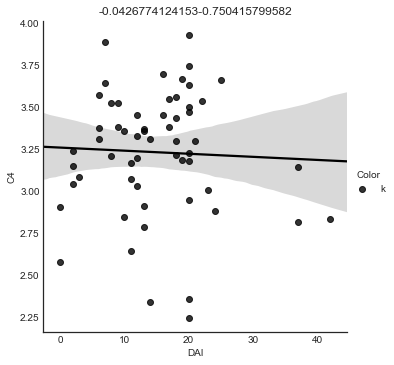

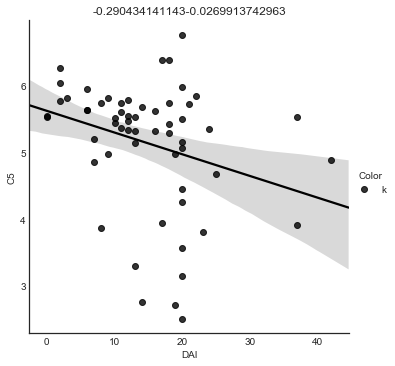

In [34]:
SaveBed(BedDF.loc[C1_Peaks], os.path.join(Dir,"Cluster1_Peaks.bed"))
SaveBed(BedDF.loc[C2_Peaks], os.path.join(Dir,"Cluster2_Peaks.bed"))
SaveBed(BedDF.loc[C3_Peaks], os.path.join(Dir,"Cluster3_Peaks.bed"))
SaveBed(BedDF.loc[C4_Peaks], os.path.join(Dir,"Cluster4_Peaks.bed"))
SaveBed(BedDF.loc[C5_Peaks], os.path.join(Dir,"Cluster5_Peaks.bed"))

SaveTable(QNormDFlog.loc[C1_Peaks], os.path.join(Dir,"Cluster1_Peaks.QNormDFlog.txt"))
SaveTable(QNormDFlog.loc[C2_Peaks], os.path.join(Dir,"Cluster2_Peaks.QNormDFlog.txt"))
SaveTable(QNormDFlog.loc[C3_Peaks], os.path.join(Dir,"Cluster3_Peaks.QNormDFlog.txt"))
SaveTable(QNormDFlog.loc[C4_Peaks], os.path.join(Dir,"Cluster4_Peaks.QNormDFlog.txt"))
SaveTable(QNormDFlog.loc[C5_Peaks], os.path.join(Dir,"Cluster5_Peaks.QNormDFlog.txt"))


def AveragePeak_Intense(C_Peaks):return QNormDFlog.loc[C_Peaks].apply(np.mean,axis=0)[Info_SampleAnoDF_SLE.index]
def LmPlot(DF,x,y,c,label,Dir):
    DF['Color']=['k']*len(DF)
    sns.lmplot(x=x, y=y,data=DF,hue='Color',palette={'k':'k'})
    p,r=scipy.stats.pearsonr(DF[x],DF[y])
    plt.title(str(p)+'-'+str(r))
    plt.savefig(os.path.join(Dir,'{}_{}_{}_lmplot.pdf'.format(x,y,label)))
    plt.show()

C1_AveragePeak_Intense,C2_AveragePeak_Intense,C3_AveragePeak_Intense,C4_AveragePeak_Intense,C5_AveragePeak_Intense=map(AveragePeak_Intense,[C1_Peaks,C2_Peaks,C3_Peaks,C4_Peaks,C5_Peaks])                        

LMDF=pd.DataFrame({'DAI':Info_SampleAnoDF_SLE['DAI'],'C1':C1_AveragePeak_Intense,'C2':C2_AveragePeak_Intense,'C3':C3_AveragePeak_Intense,'C4':C4_AveragePeak_Intense,'C5':C5_AveragePeak_Intense},index=Info_SampleAnoDF_SLE.index)           
LmPlot(LMDF,'DAI','C1','k','Correlation',Dir)
LmPlot(LMDF,'DAI','C2','k','Correlation',Dir)
LmPlot(LMDF,'DAI','C3','k','Correlation',Dir)
LmPlot(LMDF,'DAI','C4','k','Correlation',Dir)
LmPlot(LMDF,'DAI','C5','k','Correlation',Dir)




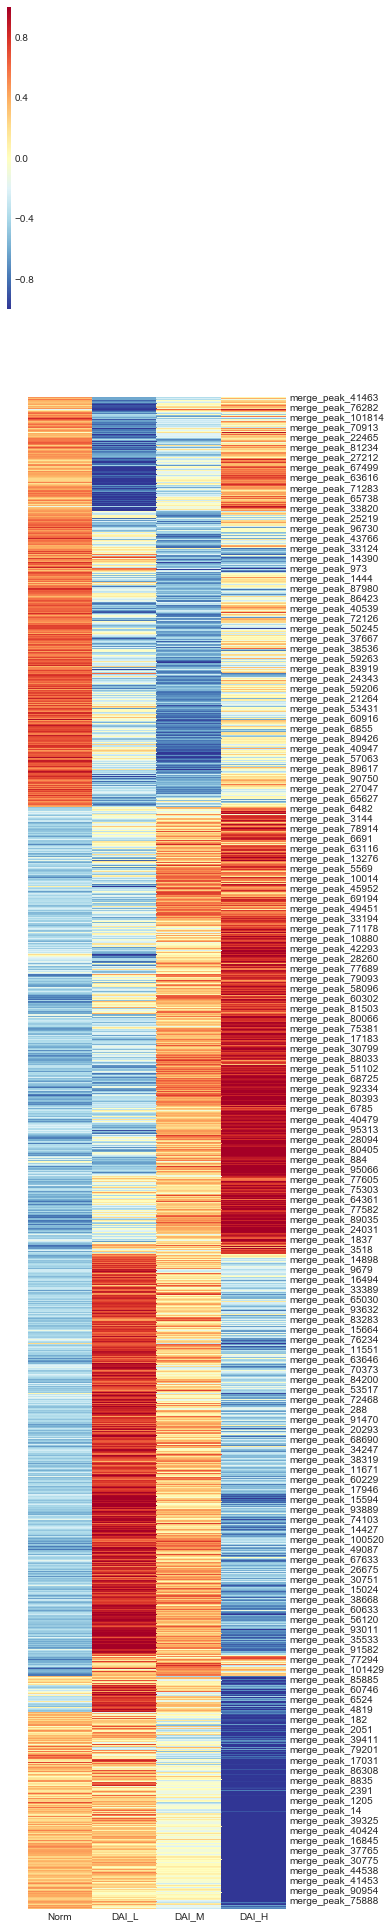

In [35]:
#Mean Peak Intensity

MeanDF=pd.DataFrame({},index=Peaks)
MeanDF['Norm']=QNormDFlog_Zscore[list(Norm_DF)].loc[Peaks].apply(np.mean,axis=1)
MeanDF['DAI_L']=QNormDFlog_Zscore[list(DAI_L_DF)].loc[Peaks].apply(np.mean,axis=1)
MeanDF['DAI_M']=QNormDFlog_Zscore[list(DAI_M_DF)].loc[Peaks].apply(np.mean,axis=1)
MeanDF['DAI_H']=QNormDFlog_Zscore[list(DAI_H_DF)].loc[Peaks].apply(np.mean,axis=1)

fig=sns.clustermap(MeanDF,cmap='RdYlBu_r',figsize=(5,35),row_cluster=False,col_cluster=False,xticklabels=list(MeanDF),linecolor=None,vmin=-1,vmax=1)                                                                                              
plt.savefig(os.path.join(Dir, 'QNormDFlog_DiffPeaks.MeanCount.Order.RdYlBu_r.pdf'))   
plt.show()


# Transcription Factor regulatory network

In [42]:
TFDir=os.path.join(Dir,'Genomica_TFRegulatoryNetwork')
Mkdir(TFDir)


In [45]:
def Range(L):return max(L)-min(L)
def Genomic_Display(GxrFile,Dir,colormap='PuOr_r',ColorDF=None,vmax=50,colorLabel=['DAI_Interval_Color'],topNum=100):
    GXR=ReadTable(GxrFile)
    FOXP3=[i for i in list(GXR.index) if ('Foxp3' in i) or ('FOXP3' in i)]
    print FOXP3
    F1=((abs(GXR)>0).apply(sum,axis=1))>len(list(GXR))*0.05 
    #AllIndex=list(set(list(GXR[F1].index)+FOXP3))
    #Index=list(set(list(GXR.apply(Range,axis=1).sort_values()[-topNum:].index)+FOXP3))
    AllIndex=list(set(list(GXR[F1].index)))
    Index=list(set(list(GXR.apply(Range,axis=1).sort_values()[-topNum:].index)))    
    GXR=GXR.loc[Index]
    GXR=GXR[~GXR.index.duplicated(keep='first')]
    GXR.to_csv(os.path.join(Dir,'GenomicMotifEnrichment.topNum{}.Heatmap.txt'.format(str(topNum))),sep='\t')
    fig=sns.clustermap(GXR,figsize=(0.25*len(list(GXR)),0.45*len(GXR)),center=0,vmin=-vmax,vmax=vmax,col_cluster=True,row_cluster=True,col_colors=ColorDF,cmap=colormap,method='average',metric='correlation')                    
    TFOrder=GXR.index[fig.dendrogram_row.reordered_ind]
    ColOrder=GXR.columns[fig.dendrogram_col.reordered_ind]
    plt.setp(fig.ax_heatmap.get_yticklabels(), rotation=0,fontsize=25)
    plt.setp(fig.ax_heatmap.get_xticklabels(), rotation=90,fontsize=15)
    fig.savefig(os.path.join(Dir,'GenomicMotifEnrichment.topNum{}.Heatmap.pdf'.format(str(topNum))))
    print TFOrder
    print ColOrder
    oGXR0=GXR.loc[TFOrder]
    oGXR=oGXR0[ColOrder]
    
    y=[0.5+i for i in range(len(oGXR))]
    x=[0.5+i for i in range(len(list(oGXR)))]
    Ylim=[0,y[-1]+0.5]
    Xlim=[0,x[-1]+0.5]
    X=[]
    Y=[]
    C=[]
    Header=list(oGXR)
    for i in range(len(list(oGXR))):
        Col=Header[i]
        C=C+list(oGXR[Col])
        X=X+[0.5+i]*len(oGXR)
        Y=Y+y

    plt.style.use('seaborn-white')
    fig=plt.figure(figsize=(0.3*len(list(oGXR)),0.28*len(oGXR)))
    ax=fig.add_axes([0.15,0.05,0.8,0.9])
    ax.set_xlim(Xlim)
    ax.set_ylim(Ylim)
    ax.set_xticks(x)
    ax.set_yticks(y)
    ax.set_xticklabels(list(oGXR),rotation='vertical')
    ax.set_yticklabels(list(oGXR.index))
    ax.scatter(X,Y,c=C,cmap='PuOr_r',s=270,vmax=vmax,vmin=-vmax)
    ax.tick_params(axis='y',length=7,labelsize=25,direction='out')
    ax.tick_params(axis='x',length=7,labelsize=15,direction='out')
   
    fig.savefig(os.path.join(Dir,'GenomicMotifEnrichment.topNum{}.Scatterplot.pdf'.format(str(topNum))))
    plt.show()
    return oGXR,ColOrder


['FOXP3_zzq', 'FOXP3']
Index([u'ZNF165(GSE65937)', u'Myc(cMyc)', u'EGR2(GSE34254)',
       u'CTCFL(GSE32465)', u'E2F7(GSE32673)', u'NRF1', u'SP1',
       u'E2F6(GSE31477)', u'E2F3(GSE71376)', u'E2F4(GSE31477)',
       ...
       u'Pou5f1', u'FOXK2', u'Foxo1', u'FOXP3_zzq', u'Sox3(GSE33059)',
       u'SOX15(GSE62909)', u'Sox10(GSE35132)', u'Sox6(GSE32627)', u'Tgif1',
       u'Crx'],
      dtype='object', length=150)
Index([u'PF52TR1', u'P135T', u'PF46TR1', u'P136T', u'P165TR2', u'P159TR2',
       u'PF55TR1', u'PF60TR1', u'PF25TR1', u'PF11TR1',
       ...
       u'NF1TR1', u'NM4TR2', u'NM2TR1', u'NM2TR2', u'NM6TR2', u'NM12TR1',
       u'PF35TR1', u'PS40T', u'NM1TR1', u'NM1TR2'],
      dtype='object', length=102)


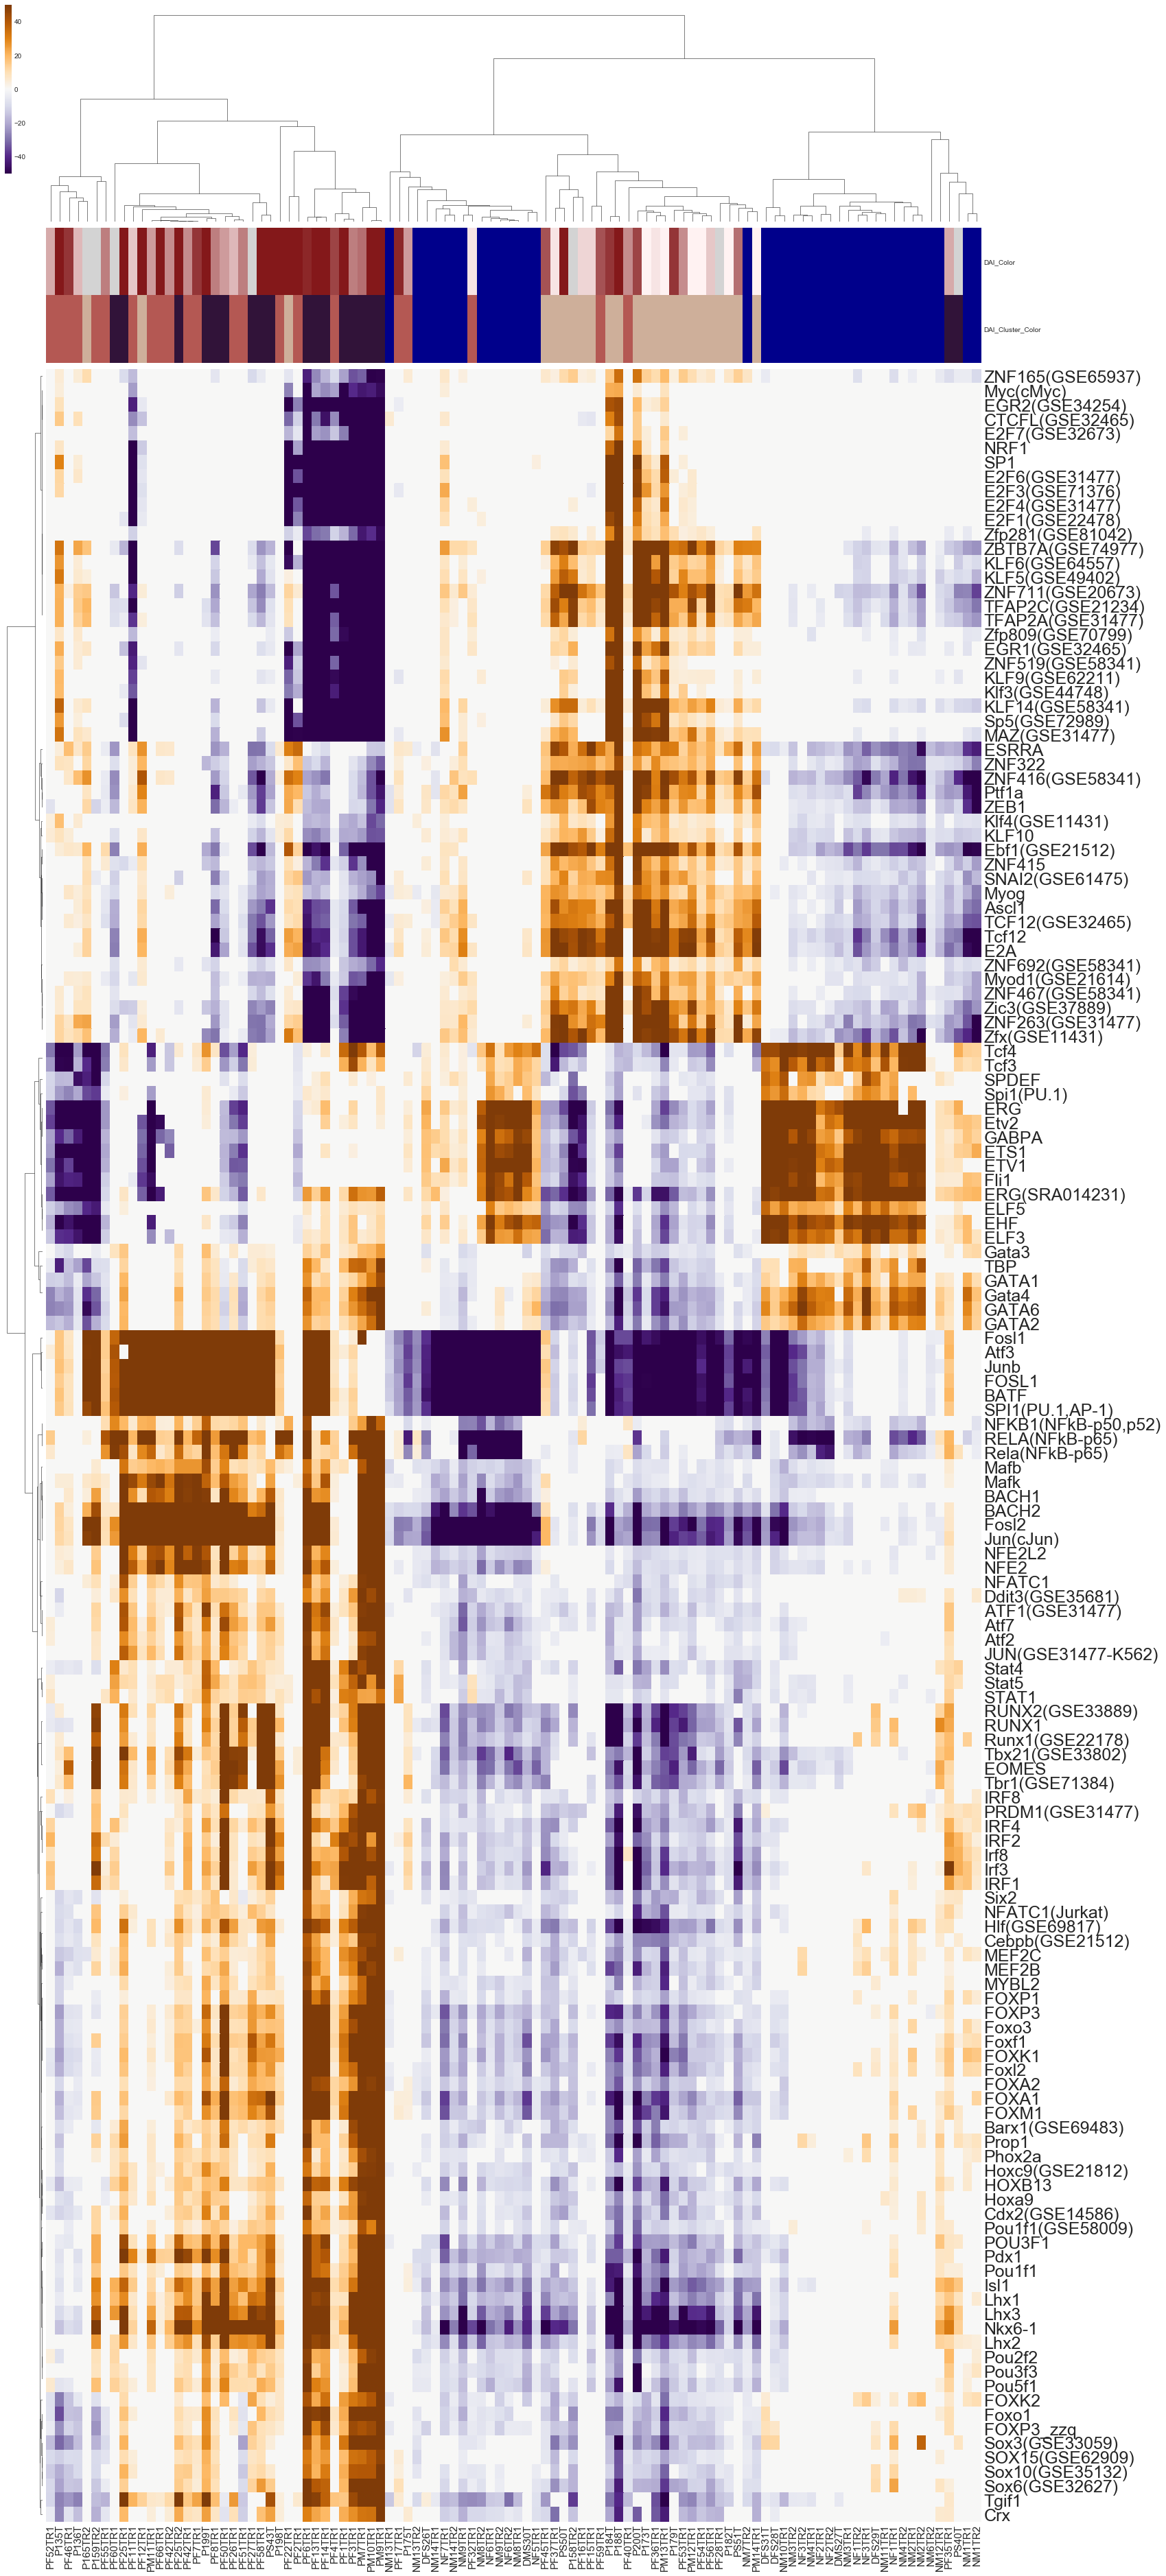

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [46]:
AllGxrFile=os.path.join(inDir, "SourceData/AllDAICluster.gxr.RenameTF.txt")                                                                                                   
AllTFGXR,ColOrder=Genomic_Display(AllGxrFile,Dir,ColorDF=SampleAnoDF[['DAI_Color','DAI_Cluster_Color']],topNum=150)




In [47]:
SeverPatients=list(SampleAnoDF[(SampleAnoDF['DAI_Cluster']=='DAI_Hi')|(SampleAnoDF['DAI_Cluster']=='DAI_Int')].index)
SeverTFs=AllTFGXR[SeverPatients].apply(np.mean,axis=1).sort_values()
SeverTFs=[i.split('(')[0].upper() for i in SeverTFs[SeverTFs>1].index]


In [48]:
NormPatients=list(SampleAnoDF[(SampleAnoDF['DAI_Cluster']=='Norm')].index)
NormTFs=AllTFGXR[NormPatients].apply(np.mean,axis=1).sort_values()
NormTFs=[i.split('(')[0].upper() for i in NormTFs[NormTFs>1].index]


### Add the expression Information to the regulatory Network

In [49]:
TF_List=[i.split('(')[0].upper() for i in list(AllTFGXR.index)]
def GetExp(ExpFile,ProbFile,TF_List):                                     
    ExpDF=ReadTable(ExpFile).T
    ExpDF['Clinical']=[i.split('_')[0] for i in list(ExpDF.index)]
    ProbDF=pd.read_table(ProbFile,sep='\t',skiprows=16)                                         
    MeanExpDF=ExpDF.groupby('Clinical').apply(np.mean).T
    FoldChange=[]
    for i in TF_List:
        MeanExp=MeanExpDF.loc[ProbDF[ProbDF['Gene Symbol']==i]['ID']]
        if len(MeanExp)==0:
            FoldChange.append(0)
        else:
            MeanExp=MeanExp.apply(np.mean,axis=0)
            FoldChange.append(MeanExp['SLE']-MeanExp['N'])
    return FoldChange
        

In [51]:
###########################################input file##################################
ExpFile1=os.path.join(inDir, "SourceData/GSE4588_ExpDF_Normalized.txt")      
ProbFile1=os.path.join(inDir, "SourceData/GPL570-55999.txt") 
FoldChange_DEseq1=GetExp(ExpFile1,ProbFile1,TF_List)

ExpFile2=os.path.join(inDir, "SourceData/GSE10325_ExpDF_Normalized.txt")   
ProbFile2=os.path.join(inDir, "SourceData/GPL96-57554.txt") 
FoldChange_DEseq2=GetExp(ExpFile2,ProbFile2,TF_List)



In [52]:
def mulp(a,b):
    if ((a<0)and (b>0)) or ((a>0)and (b<0)):
        return 0
    elif (a<0) and (b<0):
        return -a*b
    else:
        return a*b

Mean_FoldChange_DEseq=[(FoldChange_DEseq2[i]+FoldChange_DEseq1[i])/2.0 for i in range(len(FoldChange_DEseq2))]
New_TF_Enrichment=pd.DataFrame({},index=list(AllTFGXR.index))
for s in list(AllTFGXR):
    C=list(AllTFGXR[s])
    New_TF_Enrichment[s]=[mulp(Mean_FoldChange_DEseq[i],C[i]) if 'P' in s else mulp(-Mean_FoldChange_DEseq[i],C[i]) for i in range(len(Mean_FoldChange_DEseq)) ]         
        
New_TF_Enrichment_Clean=New_TF_Enrichment[(New_TF_Enrichment!=0).apply(sum,axis=1)>20]  



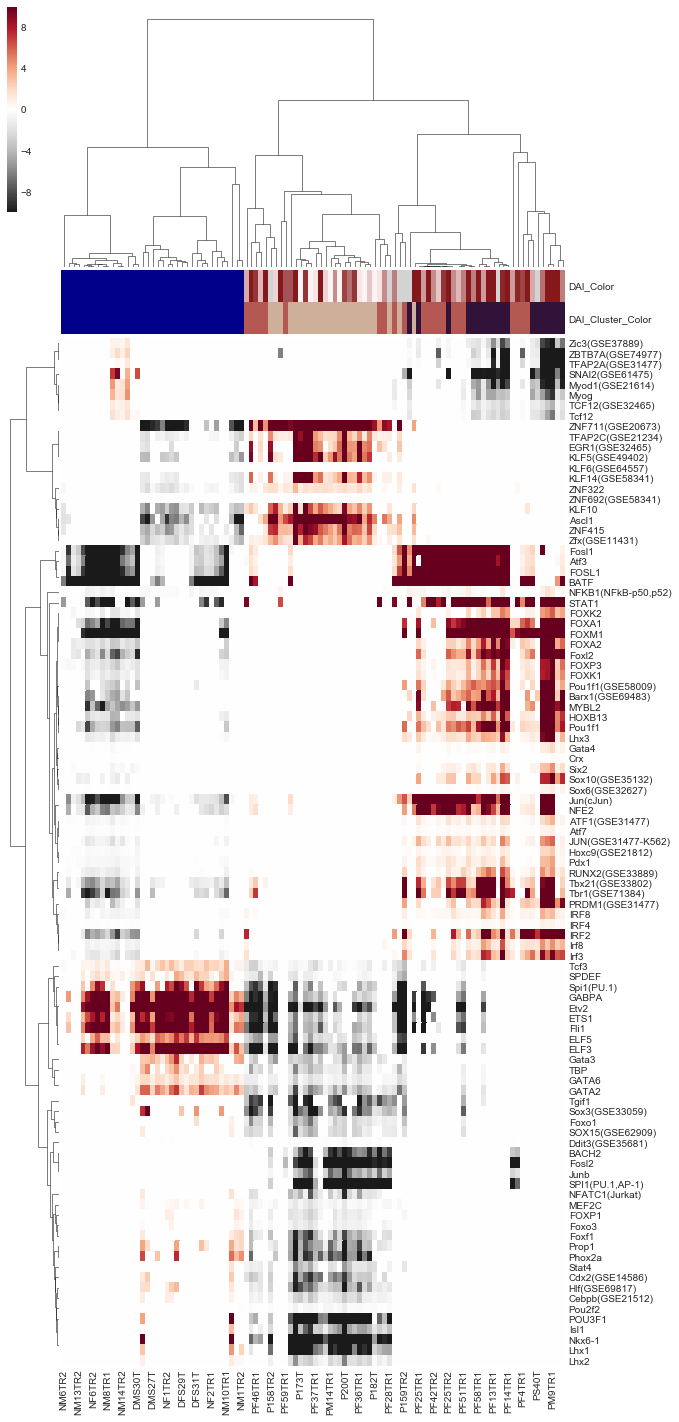

In [53]:
fig=sns.clustermap(New_TF_Enrichment_Clean,figsize=(10,25),center=0,vmin=-10,vmax=10,col_cluster=True,row_cluster=True,col_colors=SampleAnoDF[['DAI_Color','DAI_Cluster_Color']],cmap="RdGy_r",method='average',yticklabels=New_TF_Enrichment_Clean.index,metric='correlation')              
fig.savefig(os.path.join(TFDir,'TF_Enrichment_AddExpression.pdf'))
plt.show()


### CD4+ T SLE Up/Down Genes

In [54]:
def DiffGeneSelect(ExpFile,ProbFile):
    ExpDF=ReadTable(ExpFile)
    ProbDF=pd.read_table(ProbFile,sep='\t',skiprows=16)
    ProbDF.index=ProbDF['ID']
    N_ExpDF=ExpDF[[i for i in list(ExpDF) if 'N' in i]]
    SLE_ExpDF=ExpDF[[i for i in list(ExpDF) if 'SLE' in i]]
    Pval=pd.Series(scipy.stats.ttest_ind(N_ExpDF,SLE_ExpDF,axis=1)[1],index=SLE_ExpDF.index)
    N_ExpDF_Mean=N_ExpDF.apply(np.mean,axis=1)
    SLE_ExpDF_Mean=SLE_ExpDF.apply(np.mean,axis=1)
    Fdc=SLE_ExpDF_Mean-N_ExpDF_Mean
    probsUP=ExpDF[(Fdc>1)&(Pval<0.01)].index
    probsDown=ExpDF[(Fdc<-1)&(Pval<0.01)].index
    genesUP=flatten([str(i).split('///') for i in list(ProbDF.loc[probsUP]['Gene Symbol'])])
    genesDown=flatten([str(i).split('///') for i in list(ProbDF.loc[probsDown]['Gene Symbol'])])
    return [i.strip(' ') for i in genesUP if i!='nan' ],[i.strip(' ') for i in genesDown if i!='nan' ]

DiffGenesUP1,DiffGenesDown1=DiffGeneSelect(ExpFile1,ProbFile1)
DiffGenesUP2,DiffGenesDown2=DiffGeneSelect(ExpFile2,ProbFile2)
    
SLEUpGenes=[i for i in list(set(DiffGenesUP1+DiffGenesUP2)) if i not in list(set(DiffGenesDown1+DiffGenesDown2))]
SLEDownGenes=[i for i in list(set(DiffGenesDown1+DiffGenesDown2)) if i not in list(set(DiffGenesUP1+DiffGenesUP2))]
   

/Users/liuqian/anaconda2/lib/python2.7/site-packages/numpy/core/_methods.py:112: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/Users/liuqian/anaconda2/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/liuqian/anaconda2/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/liuqian/anaconda2/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [55]:
SLEUpGenes

['TAP1',
 'PGAP1',
 'TREX1',
 'IGHG4',
 'IGHG1',
 'IGHG2',
 'IGHG3',
 'IGKC',
 'IGKV1D-37',
 'ZNF707',
 'ESPL1',
 'SP110',
 'METTL13',
 'FAM84A',
 'CXCL13',
 'AKAP2',
 'POU2AF1',
 'DDX60L',
 'PARP14',
 'IGLL3P',
 'PARP12',
 'GPR114',
 'TNFSF10',
 'DTL',
 'MX2',
 'MX1',
 'OR2W1',
 'IFIT3',
 'IFIT2',
 'IFIT1',
 'XIST',
 'LOC102725426',
 'ISG15',
 'CYP27B1',
 'SNX31',
 'IGLV3-1',
 'CCDC50',
 'RPH3AL',
 'GART',
 'IGK',
 'IGJ',
 'IGH',
 'MTHFD1L',
 'IGLV4-60',
 'HES4',
 'ZNF428',
 'GUSBP11',
 'SMAD1',
 'MKRN3',
 'FOXM1',
 'ASPM',
 'NT5C3A',
 'HIST1H2BI',
 'IFI44L',
 'CISH',
 'CH17-132F21.1',
 'HERC2P3',
 'SPATS2L',
 'LOC100996643',
 'IGHV3-23',
 'BGLT3',
 'CYP2C8',
 'CDC45',
 'MYL6B',
 'IFIH1',
 'MT2A',
 'B4GALNT1',
 'TMEM254',
 'RTP4',
 'KIAA0125',
 'PRODH',
 'TWIST1',
 'CDK14',
 'CDCA7',
 'CDCA8',
 'MIR5188',
 'RP11-385F5.4',
 'LGALS3BP',
 'IGHD',
 'KLHDC7B',
 'IGHM',
 'PARD3',
 'LOC100506314',
 'E2F8',
 'IFI44',
 'TRIM14',
 'LOC101928910',
 'TIGIT',
 'CHI3L2',
 'ADAMTS5',
 'LOC101929109'

In [56]:
SLEDownGenes

['ZFY',
 'KLRB1',
 'FAM124B',
 'PLK2',
 'FADS3',
 'KHDC1',
 'APOC4-APOC2',
 'APOC2',
 'RARS2',
 'NRIP3',
 'COL6A6',
 'UPB1',
 'ZDHHC11',
 'KIAA1429',
 'SLC30A1',
 'FRY',
 'NALCN-AS1',
 'ZNF709',
 'COL11A2',
 'LOC101929694',
 'CXorf57',
 'GAGE5',
 'EIF1AY',
 'GAGE7',
 'DSC1',
 'LOC401320',
 'KLK12',
 'MICAL2',
 'MAGI1',
 'B3GALTL',
 'TYSND1',
 'SEPT10',
 'NF2',
 'ARHGEF12',
 'DDX3Y',
 'TDRD6',
 'GPAT2',
 'POSTN',
 'GAS5-AS1',
 'SHOX2',
 'CCDC157',
 'ATP2B1',
 'IQCH',
 'SETD7',
 'UBR4',
 'MORN4',
 'DZIP1',
 'CCDC136',
 'C18orf12',
 'APOC4',
 'SYT7',
 'LOC100996693',
 'RNF103',
 'LOC101928730',
 'TAS1R1',
 'SPEG',
 'LOC100130264',
 'ARHGAP19',
 'ACTA2',
 'GREM2',
 'ZDHHC11B',
 'N6AMT1',
 'CACNA1G',
 'DNAJC27',
 'NUAK1',
 'MROH2B',
 'DPH6',
 'KCNQ1OT1',
 'GAB1',
 'SLC25A5-AS1',
 'CLTC',
 'TMEM185B',
 'COL3A1',
 'SPRNP1',
 'VIM',
 'IL1R2',
 'APOE',
 'CLEC7A',
 'PLA2G12B',
 'TCP11L2',
 'DDX51',
 'NT5E',
 'AFF2',
 'THBS1',
 'AHSA2',
 'ITPKB',
 'C6orf147',
 'TBC1D26',
 'PIK3R1',
 'B4GALT1',
 '

# Signature Enrichment 

In [58]:
GSDir=os.path.join(Dir,'GeneSetEnrichment')
Mkdir(GSDir)

In [61]:
IntersectFile=os.path.join(outDir,'AllPeaks.intersect.GeneRegulatoryRegion.txt')
Comd='intersectBed -a {} -b {} -wa -wb > {}'.format(RegulatoryRegions, PeakBedF,IntersectFile)                   
os.system(Comd)
IntersectDF=pd.read_table(IntersectFile,sep='\t',index_col=None,header=None)



In [62]:
IntersectFile=os.path.join(outDir,'AllPeaks.intersect.GeneRegulatoryRegion.txt')
IntersectDF=pd.read_table(IntersectFile,sep='\t',index_col=None,header=None)


In [65]:
#Genes Sets
#Signature 
def GetSignatureEnrichment(Signature):
    SignatureDF=ReadTable(Signature)
    SignatureDict={}
    for gs in list(SignatureDF):
        SignatureDict[gs]=list(SignatureDF[gs].dropna())
    
    IntersectDF=pd.read_table(IntersectFile,sep='\t',index_col=None,header=None)
 
    
    AllTabDF=pd.DataFrame({},index=list(QNormDFlog.index))
    for gs in SignatureDict:
        print gs
        AllPeaks=flatten([list(IntersectDF[IntersectDF[3]==g][9]) for g in SignatureDict[gs]])
        AllTabDF[gs]=[1 if i in AllPeaks else 0 for i in list(QNormDFlog.index)]

    SaveTable(AllTabDF,os.path.join(GSDir,'AllManualSelected_GeneSets_RemoveOverlap500_inAllPeaks.tab'))
    TabDF=AllTabDF.loc[AllDiffPeaks]


    Cluster1_TabDF=TabDF.loc[C1_Peaks]
    Cluster2_TabDF=TabDF.loc[C2_Peaks]
    Cluster3_TabDF=TabDF.loc[C3_Peaks]
    Cluster4_TabDF=TabDF.loc[C4_Peaks]
    Cluster5_TabDF=TabDF.loc[C5_Peaks]

    GeneNum=[len(SignatureDict[i]) for i in list(TabDF)]
    SizeDF_gs=pd.DataFrame({'Cluster1':Cluster1_TabDF.apply(sum,axis=0)/GeneNum,'Cluster2':Cluster2_TabDF.apply(sum,axis=0)/GeneNum,'Cluster3':Cluster3_TabDF.apply(sum,axis=0)/GeneNum,'Cluster4':Cluster4_TabDF.apply(sum,axis=0)/GeneNum,'Cluster5':Cluster5_TabDF.apply(sum,axis=0)/GeneNum},index=list(TabDF))

    ColorDF_gs=pd.DataFrame({},index=list(TabDF))
    def Fisher(Cluster_TabDF,AllTabDF):
        SumCluster=Cluster_TabDF.apply(sum,axis=0)
        SumAllTabDF=AllTabDF.apply(sum,axis=0)
        Nc=len(Cluster_TabDF)
        N=len(AllTabDF)
        Pval=[]
        for gs in list(Cluster1_TabDF):
            Ncgs=SumCluster[gs]
            Ngs=SumAllTabDF[gs]
            _,p=scipy.stats.fisher_exact([[Ncgs,Ngs-Ncgs],[Nc-Ncgs,(N-Nc)-(Ngs-Ncgs)]],alternative='greater')
            Pval.append(p)
        return Pval 

    ColorDF_gs['Cluster1']=Fisher(Cluster1_TabDF,AllTabDF)
    ColorDF_gs['Cluster2']=Fisher(Cluster2_TabDF,AllTabDF)
    ColorDF_gs['Cluster3']=Fisher(Cluster3_TabDF,AllTabDF)
    ColorDF_gs['Cluster4']=Fisher(Cluster4_TabDF,AllTabDF)
    ColorDF_gs['Cluster5']=Fisher(Cluster5_TabDF,AllTabDF)
    ColorDF_gs=-np.log10(ColorDF_gs)
    return ColorDF_gs,SizeDF_gs

def CircularPlot2(df,Sizedf,FileLabel,Dir,vmin=0,vmax=2.5,SizeWeight=500,cmap='Spectral_r'):
    Indexs=list(df.index)
    Columns=list(df.columns)
    DF=pd.DataFrame(np.array(df))
    SizeDF=pd.DataFrame(np.array(Sizedf))
    
    plt.style.use('seaborn-white')
    fig=plt.figure(figsize=(0.7*len(list(DF)),0.45*len(DF)))
    ax=fig.add_axes([0.55,0.25,0.4,0.7])
    X=[i for i in range(1,len(list(DF))+1)]*len(DF)
    Y=sorted([i for i in range(1,len(DF)+1)]*len(list(DF)))
    Color=[]
    Size=[]
    for i in DF.index:
        Color=Color+list(DF.loc[i])
        Size=Size+list(SizeDF.loc[i])
    plt.title('Color:{}-{}\nSize:{}-{}'.format(str(vmin),str(vmax),str(min(Size)),str(max(Size))))
    Size=SizeWeight*np.array(Size)
    ax.scatter(X,Y,c=Color,cmap=cmap,s=Size,edgecolors='none',linewidths=0,vmin=vmin,vmax=vmax)
    ax.set_xlim([0.5,len(list(DF))+0.5])
    ax.set_ylim([0.6,len(DF)+0.6])
    ax.set_xticks([i for i in range(1,len(list(DF))+1)])
    ax.set_yticks([i for i in range(1,len(DF)+1)])
    ax.set_xticklabels(Columns,rotation='vertical')
    ax.set_yticklabels(Indexs)
    ax.tick_params(axis='y',length=5,labelsize=15,direction='out')
    ax.tick_params(axis='x',length=5,labelsize=15,direction='out')
    fig.savefig(os.path.join(Dir,FileLabel+'.ScatterPlot.pdf'))
    DF.index=Indexs
    DF.columns=Columns
    SizeDF.index=Indexs
    SizeDF.columns=Columns
    SaveTable(DF,os.path.join(Dir,FileLabel+'.ScatterPlot.Color.txt'))
    SaveTable(SizeDF,os.path.join(Dir,FileLabel+'.ScatterPlot.Size.txt'))
    plt.show()

    
    

In [66]:
ColorDF_gs,SizeDF_gs=GetSignatureEnrichment(Signature)
ColorDF_gs_KEGG,SizeDF_gs_KEGG=GetSignatureEnrichment(Signature_KEGG)
ColorDF_gs_MSig,SizeDF_gs_MSig=GetSignatureEnrichment(Signature_MSig)


SLE(KEGG)
Systemic lupus erythematosus
M1 Macrophage Polarization
Naive T specific
G2/M
Glucose Deprivation
Co-Inhibition
Th2
Th1
Treg_Specific
cellular response to cytokine stimulus
Inflammation
M2 Macrophage Polarization
Type 1 diabetes
Th17_Speficic
Glycogen Metabolism
SLE Down regulated genes in CD4+ T cell
Effect MemT specific
Trest
SLE Up regulated genes in CD4+ T cell
Tfh
Glycolysis
Rheumatoid arthritis
tgf_beta_signaling_pathway
Th2_Specific
TCA cycle
Tct_Specific
Centor MemT specific
Treg Exhaustion
Cytolytics effector pathway
Type I Interferon response
Type II Interferon Response
Hypoxia/HIF regulated
Ulcerative colitis
Co-Stimulation
Lupus nephritis
Treg
Tph
Lipid mediators
Th17
Tcell_Activation
Chemokine_Single
CD8 T Cell Activation
Anti-inflammatory
Th1_Specific
G1/S
Pro inflammatory
Tct
Allergy
T cell Exhaustion
Anergy
Pentose Phosphate Pathway
TCell Terminal Differentiation
Inflammatory bowel disease
Acute lymphoblastic leukemia
Systemic sclerosis
g_tight_junction
g_basa

/Users/liuqian/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2881: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,2

regulation_of_b_cell_receptor_signaling_pathway
amine_biosynthetic_process
ras_protein_signal_transduction
regulation_of_cellular_amide_metabolic_process
monosaccharide_transport
regulation_of_extrinsic_apoptotic_signaling_pathway_via_death_domain_receptors
transcytosis
primary_amino_compound_metabolic_process
cell_killing
somatic_diversification_of_immune_receptors_via_somatic_mutation
response_to_interleukin_4
ribosomal_small_subunit_assembly
regulation_of_response_to_reactive_oxygen_species
granulocyte_differentiation
catecholamine_biosynthetic_process
c21_steroid_hormone_biosynthetic_process
positive_regulation_of_viral_process
nuclear_envelope_reassembly
positive_regulation_of_vasoconstriction
electron_transport_chain
negative_regulation_of_dna_biosynthetic_process
alditol_metabolic_process
iron_ion_import
cellular_response_to_nutrient
regulation_of_cysteine_type_endopeptidase_activity_involved_in_apoptotic_signaling_pathway
negative_regulation_of_intracellular_steroid_hormone_rec

negative_regulation_of_cd4_positive_alpha_beta_t_cell_activation
enzyme_linked_receptor_protein_signaling_pathway
mitochondrial_fusion
peptidyl_cysteine_modification
negative_regulation_of_viral_transcription
prostanoid_metabolic_process
negative_regulation_of_glycoprotein_metabolic_process
nephron_tubule_formation
carnitine_metabolic_process
decidualization
cellular_response_to_radiation
signal_transduction_by_protein_phosphorylation
negative_regulation_of_cation_channel_activity
negative_regulation_of_translational_initiation
nucleotide_excision_repair_preincision_complex_assembly
monosaccharide_metabolic_process
t_cell_receptor_signaling_pathway
positive_regulation_of_camp_mediated_signaling
regulation_of_mesenchymal_cell_apoptotic_process
regulation_of_odontogenesis
glucosamine_containing_compound_metabolic_process
nucleotide_excision_repair_dna_gap_filling
positive_regulation_of_oligodendrocyte_differentiation
cell_communication_by_electrical_coupling
negative_regulation_of_reacti

coenzyme_a_metabolic_process
dna_demethylation
definitive_hemopoiesis
non_canonical_wnt_signaling_pathway
positive_regulation_of_vascular_permeability
regulation_of_interleukin_10_secretion
regulation_of_glycogen_metabolic_process
erk1_and_erk2_cascade
regulation_of_lymphocyte_migration
positive_regulation_of_receptor_activity
positive_regulation_of_interleukin_13_production
response_to_misfolded_protein
neutral_amino_acid_transport
tissue_regeneration
peptide_secretion
ganglioside_biosynthetic_process
response_to_amine
negative_regulation_of_signal_transduction_in_absence_of_ligand
amino_acid_betaine_transport
regulation_of_nlrp3_inflammasome_complex_assembly
estrogen_metabolic_process
activation_of_phospholipase_c_activity
negative_regulation_of_reproductive_process
regulation_of_t_cell_proliferation
bicarbonate_transport
negative_regulation_of_cation_transmembrane_transport
positive_regulation_of_dna_repair
cellular_sodium_ion_homeostasis
negative_regulation_of_intracellular_estroge

cellular_response_to_biotic_stimulus
transforming_growth_factor_beta_receptor_signaling_pathway
regulation_of_sodium_ion_transport
positive_regulation_of_innate_immune_response
regulation_of_arp2_3_complex_mediated_actin_nucleation
chromosome_condensation
carbohydrate_transport
primitive_streak_formation
positive_regulation_of_extrinsic_apoptotic_signaling_pathway
regulation_of_anoikis
regulation_of_cell_activation
regulation_of_retinoic_acid_receptor_signaling_pathway
response_to_copper_ion
nuclear_export
positive_regulation_of_immune_response
antigen_processing_and_presentation_of_peptide_antigen
regulation_of_tyrosine_phosphorylation_of_stat1_protein
positive_regulation_of_p38mapk_cascade
regulation_of_translational_fidelity
heterophilic_cell_cell_adhesion_via_plasma_membrane_cell_adhesion_molecules
regulation_of_fibroblast_migration
somatic_recombination_of_immunoglobulin_gene_segments
negative_regulation_of_erad_pathway
regulation_of_extracellular_matrix_disassembly
regulation_of_

positive_regulation_of_cation_channel_activity
peptidyl_lysine_methylation
negative_regulation_of_catalytic_activity
negative_regulation_of_natural_killer_cell_mediated_immunity
mitochondrial_respiratory_chain_complex_i_biogenesis
regulation_of_cell_killing
somatic_stem_cell_division
vasoconstriction
macrophage_differentiation
chromatin_disassembly
regulation_of_lamellipodium_assembly
negative_regulation_of_sodium_ion_transport
mitotic_g2_dna_damage_checkpoint
negative_regulation_of_viral_process
regulation_of_anion_transport
positive_regulation_of_sodium_ion_transmembrane_transport
positive_regulation_of_lymphocyte_apoptotic_process
response_to_increased_oxygen_levels
estrogen_biosynthetic_process
non_recombinational_repair
negative_regulation_of_oxidative_stress_induced_intrinsic_apoptotic_signaling_pathway
positive_regulation_of_erythrocyte_differentiation
rhodopsin_mediated_signaling_pathway
regulation_of_cytoplasmic_transport
regulation_of_response_to_dna_damage_stimulus
positive_

positive_regulation_of_cellular_protein_localization
somatic_diversification_of_immune_receptors
response_to_ethanol
regulation_of_dna_repair
b_cell_activation_involved_in_immune_response
positive_regulation_of_membrane_depolarization
negative_regulation_of_response_to_oxidative_stress
response_to_yeast
bile_acid_and_bile_salt_transport
regulation_of_natural_killer_cell_activation
glucan_biosynthetic_process
regulation_of_glycoprotein_metabolic_process
apoptotic_cell_clearance
macromolecular_complex_disassembly
positive_regulation_of_response_to_oxidative_stress
odontogenesis
mitotic_nuclear_division
peptidyl_proline_modification
response_to_lead_ion
creatine_metabolic_process
vesicle_targeting
negative_regulation_of_protein_tyrosine_kinase_activity
myoblast_fusion
interstrand_cross_link_repair
cell_cell_adhesion
activation_of_anaphase_promoting_complex_activity
aerobic_respiration
arginine_metabolic_process
response_to_arsenic_containing_substance
regulation_of_gluconeogenesis
product

positive_regulation_of_alpha_beta_t_cell_activation
histone_h4_acetylation
pyridine_containing_compound_biosynthetic_process
regulation_of_protein_export_from_nucleus
adaptive_immune_response
odontogenesis_of_dentin_containing_tooth
positive_regulation_of_camp_metabolic_process
monocarboxylic_acid_biosynthetic_process
histone_methylation
dendritic_cell_differentiation
nucleoside_triphosphate_biosynthetic_process
response_to_retinoic_acid
phenol_containing_compound_metabolic_process
dna_damage_response_detection_of_dna_damage
regulation_of_centriole_replication
regulation_of_b_cell_activation
virion_assembly
nucleoside_bisphosphate_biosynthetic_process
positive_regulation_of_cytokine_production
vascular_process_in_circulatory_system
positive_regulation_of_wound_healing
negative_regulation_of_intrinsic_apoptotic_signaling_pathway_in_response_to_dna_damage
pyrimidine_containing_compound_salvage
regulation_of_cell_adhesion_mediated_by_integrin
regulation_of_interferon_gamma_biosynthetic_pr

positive_regulation_of_phospholipase_activity
cellular_response_to_growth_hormone_stimulus
activation_of_transmembrane_receptor_protein_tyrosine_kinase_activity
establishment_of_cell_polarity
negative_regulation_of_tumor_necrosis_factor_mediated_signaling_pathway
negative_regulation_of_catecholamine_secretion
positive_regulation_of_cyclin_dependent_protein_kinase_activity
negative_regulation_of_chondrocyte_differentiation
proximal_distal_pattern_formation
negative_regulation_of_potassium_ion_transport
response_to_laminar_fluid_shear_stress
negative_regulation_of_coagulation
regulation_of_t_cell_mediated_immunity
negative_regulation_of_transmembrane_receptor_protein_serine_threonine_kinase_signaling_pathway
positive_regulation_of_tyrosine_phosphorylation_of_stat3_protein
lipoxygenase_pathway
calcium_mediated_signaling
protein_depolymerization
negative_regulation_of_protein_maturation
histone_phosphorylation
regulation_of_jnk_cascade
regulation_of_peptidase_activity
regulation_of_phospho

amino_acid_transport
positive_regulation_of_nik_nf_kappab_signaling
regulation_of_epidermal_growth_factor_activated_receptor_activity
positive_regulation_of_interleukin_12_production
modified_amino_acid_transport
nucleoside_diphosphate_metabolic_process
regulation_of_leukocyte_degranulation
regulation_of_establishment_of_protein_localization_to_mitochondrion
regulation_of_antigen_receptor_mediated_signaling_pathway
response_to_calcium_ion
blastoderm_segmentation
negative_regulation_of_map_kinase_activity
regulation_of_cell_substrate_adhesion
negative_regulation_of_response_to_external_stimulus
positive_regulation_of_tyrosine_phosphorylation_of_stat5_protein
regulation_of_secondary_metabolic_process
positive_regulation_of_cell_adhesion
regulation_of_interleukin_4_production
mature_b_cell_differentiation
cell_matrix_adhesion
regulation_of_transmission_of_nerve_impulse
regulation_of_autophagy
sulfur_compound_biosynthetic_process
semaphorin_plexin_signaling_pathway
regulation_of_oligodendr

serine_family_amino_acid_biosynthetic_process
renal_filtration
immune_response_regulating_cell_surface_receptor_signaling_pathway
negative_regulation_of_sterol_transport
regulation_of_isotype_switching
regulation_of_protein_localization_to_nucleus
s_adenosylmethionine_metabolic_process
alpha_linolenic_acid_metabolic_process
regulation_of_cyclin_dependent_protein_kinase_activity
cellular_response_to_prostaglandin_e_stimulus
positive_regulation_of_reactive_oxygen_species_biosynthetic_process
cell_proliferation_in_forebrain
negative_regulation_of_receptor_binding
toxin_metabolic_process
regulation_of_erythrocyte_differentiation
granulocyte_activation
positive_regulation_of_b_cell_mediated_immunity
osteoclast_differentiation
inner_dynein_arm_assembly
regulation_of_removal_of_superoxide_radicals
regulation_of_phospholipase_a2_activity
response_to_salt
cellular_glucose_homeostasis
erythrocyte_homeostasis
negative_regulation_of_notch_signaling_pathway
nuclear_chromosome_segregation
regulation

endocrine_process
inactivation_of_mapk_activity
purine_nucleobase_metabolic_process
response_to_hydrogen_peroxide
endoplasmic_reticulum_calcium_ion_homeostasis
negative_regulation_of_interleukin_8_production
amp_metabolic_process
peptidyl_tyrosine_autophosphorylation
chromatin_modification
negative_regulation_of_glucose_transport
bile_acid_biosynthetic_process
terpenoid_metabolic_process
cellular_response_to_leptin_stimulus
peptide_transport
positive_regulation_of_dna_binding
negative_regulation_of_pathway_restricted_smad_protein_phosphorylation
regulation_of_nuclease_activity
diol_metabolic_process
positive_regulation_of_peptidyl_threonine_phosphorylation
prostate_gland_growth
regulation_of_substrate_adhesion_dependent_cell_spreading
formation_of_translation_preinitiation_complex
negative_regulation_of_peptidyl_serine_phosphorylation
positive_regulation_of_protein_tyrosine_kinase_activity
negative_regulation_of_necrotic_cell_death
negative_regulation_of_cell_adhesion
cellular_componen

positive_regulation_of_protein_acetylation
proteoglycan_biosynthetic_process
regulation_of_interleukin_13_production
hemostasis
response_to_metal_ion
positive_regulation_of_release_of_sequestered_calcium_ion_into_cytosol
synapse_assembly
regulation_of_plasma_lipoprotein_particle_levels
chemokine_mediated_signaling_pathway
intracellular_receptor_signaling_pathway
positive_regulation_of_chondrocyte_differentiation
regulation_of_autophagosome_assembly
negative_regulation_of_cytokine_production_involved_in_immune_response
regulation_of_glucose_metabolic_process
macroautophagy
maintenance_of_cell_polarity
detection_of_abiotic_stimulus
lamellipodium_assembly
regulation_by_virus_of_viral_protein_levels_in_host_cell
regulation_of_protein_deacetylation
positive_regulation_of_substrate_adhesion_dependent_cell_spreading
regulation_of_glutamate_secretion
regulation_of_inflammatory_response_to_antigenic_stimulus
regulation_of_hemopoiesis
chromosome_localization
adenylate_cyclase_activating_dopamine

regulation_of_production_of_molecular_mediator_of_immune_response
positive_regulation_of_non_canonical_wnt_signaling_pathway
interferon_gamma_production
regulation_of_lymphocyte_differentiation
regulation_of_mitochondrial_translation
negative_regulation_of_protein_autophosphorylation
mitochondrial_transport
negative_regulation_of_cell_death
regulation_of_release_of_sequestered_calcium_ion_into_cytosol_by_sarcoplasmic_reticulum
exocytosis
regulation_of_cellular_protein_localization
cellular_protein_complex_assembly
leukocyte_cell_cell_adhesion
negative_regulation_of_substrate_adhesion_dependent_cell_spreading
regulation_of_protein_insertion_into_mitochondrial_membrane_involved_in_apoptotic_signaling_pathway
regulation_of_cytokinesis
pyrimidine_nucleoside_triphosphate_metabolic_process
positive_regulation_of_steroid_metabolic_process
protein_localization_to_cilium
cellular_response_to_external_stimulus


In [ ]:
Celltypes=['Naive T specific','Effect MemT specific','Tfh','Tph','Treg_Specific','Th17_Speficic','Th1_Specific','Th2_Specific','Tct_Specific']
Functions=['SLE Down regulated genes in CD4+ T cell','tgf_beta_signaling_pathway','SLE Up regulated genes in CD4+ T cell','Type I Interferon response','Type II Interferon Response','Tcell_Activation','Inflammation','Chemokine_Single','Co-Stimulation','TCell Terminal Differentiation','T cell Exhaustion','Treg Exhaustion']
Diseases=['Systemic lupus erythematosus','Type 1 diabetes','Rheumatoid arthritis','Ulcerative colitis','Systemic sclerosis']                                                                     

CircularPlot2(ColorDF_gs,SizeDF_gs,'MannuallySelectedSignatures',GSDir,vmin=0,vmax=5,SizeWeight=400,cmap='pink_r')
CircularPlot2(ColorDF_gs.loc[Celltypes],SizeDF_gs.loc[Celltypes],'MannuallySelectedSignatures.Celltypes',GSDir,vmin=0,vmax=5,SizeWeight=400,cmap='pink_r')
CircularPlot2(ColorDF_gs.loc[Functions],SizeDF_gs.loc[Functions],'MannuallySelectedSignatures.Functions',GSDir,vmin=0,vmax=5,SizeWeight=400,cmap='pink_r')
CircularPlot2(ColorDF_gs.loc[Diseases],SizeDF_gs.loc[Diseases],'MannuallySelectedSignatures.Disease',GSDir,vmin=0,vmax=5,SizeWeight=400,cmap='pink_r')



In [ ]:
CircularPlot2(ColorDF_gs_KEGG,SizeDF_gs_KEGG,'MannuallySelectedSignatures.KEGG',GSDir,vmin=0,vmax=5,SizeWeight=400,cmap='pink_r')
CircularPlot2(ColorDF_gs_MSig,SizeDF_gs_MSig,'MannuallySelectedSignatures.MSig',GSDir,vmin=0,vmax=5,SizeWeight=400,cmap='pink_r')                                                              

